# IBM Coursera Capstone Project 
---

## Table of Contents

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology and Results](#methodology)
* [Discussion](#results)
* [Conclusion](#conclusion)

<a id='introduction'></a>

## Introduction: Business Problem

In this project, we are going to compare the neighborhoods of the **New York City** in the US and the city of **Toronto** in Canada, and determine how similar they are in terms of businesses. We will analyze for both cities

- what types of businesses are more likely to thrive;
- what neighborhoods are suitable for each type of business; 
- what types of businesses are less desirable.

The results of the project will enable more effective decisions making for business people who want to start their business in these two big cities. 

<a id='data'></a>

## Data


Based on definition of our problem, following data sources will be needed to extract/generate the required information:

* Neiborhood coordinates for New York from **IBM Developer Skills Network**
* Neiborhood coordinates for Toronto from **Wikipedia**
* Venue data for both New York and Toronto from **FOURSQURE**

<a id='methodology'></a>

## Methodology and Results

Code in this section is based on `DP0701EN-3-3-2-Neighborhoods-New-York-py-v2.0`, which is part of a lab material in this course (Applied Data Science Capstone).

0. [Importing relevant modules](#ch0)
1. [Data for New York](#prep-data)
    1. [Neighborhood data of NYC](#nbhd_data)
        1. [Downloading and saving data](#download-nbhd)
        2. [Saving the neighborhood data into a pandas dataframe](#load-json)
    2. [Venue data of NYC](#venue_data)
        1. [Downloading and saving venue data from Foursquare](#4sq_venue_data)
        2. [Loading the saved data into a pandas dataframe](#load_venue_data)
        1. [Checking venue numbers for each nbhd](#venue_num)
        2. [One-hot on venue category variable](#one-hot-venue)
        3. [Most common categories](#most-common-cate)
    3. [Clustering](#clustering)
        1. [Examing clusters](#exam-clust)
2. [Data for Toronto](#prep-data-tor)
    1. [Neighborhood data of Toronto](#nbhd_data_tor)
        1. [Downloading and saving data](#download-nbhd-tor)
        2. [Saving the neighborhood data into a pandas dataframe](#lldata_tor)
    2. [Venue data of Toronto](#venue_data_tor)
        1. [Downloading and saving venue data from Foursquare](#4sq_venue_data_tor)
        2. [Loading the saved data into a pandas dataframe](#load_venue_data_tor)
        1. [Checking venue numbers for each nbhd](#venue_num_tor)
        2. [One-hot on venue category variable](#one-hot-venue_tor)
        3. [Most common categories](#most-common-cate_tor)
    3. [Clustering](#clustering_tor)
        1. [Examing clusters](#exam-clust_tor)
3. [Exploratory Data Analysis](#EDA)
	1. [Top 10 Common Venue Categories in NYC](#comv)
	2. [Top 10 Common Venue Categories in Toronto](#comv-tor)
	3. [Top 10 Venue Categories in Most NYC Neighborhoods](#comvc)
	4. [Top 10 Venue Categories in Most Toronto Neighborhoods](#comvc-tor)
	5. [Rare Venue Categories in NYC](#rarevc)
	6. [Rare Venue Categories in Toronto](#rarevc-tor)
	7. [Top 10 Common Venue Categories in both NYC and Toronto](#comv-nt)
	8. [Rare Categories in both NYC and Toronto](#rarevc-nt)

<a id='ch0'></a>
## 0. Importing relevant modules and plotting configurations

In [1]:
import numpy as np
import pandas as pd


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
import folium # map rendering library
from IPython.display import HTML
import time

print('Libraries imported.')

Libraries imported.


In [2]:
# plotting configurations that will be used later
# Reference: https://github.com/ammar1y

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

 <a id='prep-data'></a>
 ## 1. Data for New York City
 <a id='nbhd_data'></a>
### 1.1 Coordinates of neighborhoods in NYC
<a id='download-nbhd'></a>
#### Downloading and saving neighborhood data of New York City

Once downloaded, we save the data locally so that we can do data experiments without repeatedly downloading the data.

In [3]:
# # We only need to do this once. 
# !wget -q -O './capstone_data/newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
# print('Data downloaded!')

<a id='load-json'></a>
#### Loading the saved neighborhood JSON data for New York City 

In [4]:
with open('./capstone_data/newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
# newyork_data
nyc_neighborhoods_data = newyork_data['features']
nyc_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

<a id='json2pd'></a>
#### Saving the neighborhood data into a pandas dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyc_neighborhoods_data:
    borough             = data['properties']['borough'] 
    neighborhood_name   = data['properties']['name']
    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append(
                        {'Borough'     : borough,
                         'Neighborhood': neighborhood_name,
                         'Latitude'    : neighborhood_lat,
                         'Longitude'   : neighborhood_lon}, 
                        ignore_index=True)

In [6]:
nyc_neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_neighborhoods['Borough'].unique()),
        nyc_neighborhoods.shape[0])
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Transforming data further (needed later for the venue data)

In this dataframe, there are neighborhoods that share the same name but are located in different boroughs as shown below:

In [8]:
nnvc = nyc_neighborhoods['Neighborhood'].value_counts()
nnvc[nnvc > 1]

Sunnyside      2
Bay Terrace    2
Murray Hill    2
Chelsea        2
Name: Neighborhood, dtype: int64

In [9]:
nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == 'Bay Terrace']

Borough Neighborhood   Latitude  Longitude
175         Queens  Bay Terrace  40.782843 -73.776802
235  Staten Island  Bay Terrace  40.553988 -74.139166

To deal with this case, we will include the borough name in the name of these neighborhoods. For example, "Bay Terrace" neighborhood which is located in "Staten Island" borough will be named "Bay Terrace, Staten Island" and the one in "Queens" will be named "Bay Terrace, Queens":

In [10]:
for i in range(nyc_neighborhoods.shape[0]):
    nyn_ = nyc_neighborhoods.loc[i, 'Neighborhood']
    if nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == nyn_].shape[0] > 1:
        ind_ = nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == nyn_].index.tolist()
        for j in ind_:
            nyb__ = nyc_neighborhoods.loc[j, 'Borough']
            nyc_neighborhoods.loc[j, 'Neighborhood'] = nyn_ + ', ' + nyb__

In [11]:
nyc_neighborhoods[nyc_neighborhoods['Neighborhood'].str.startswith('Bay Terrace')]

Borough                Neighborhood   Latitude  Longitude
175         Queens         Bay Terrace, Queens  40.782843 -73.776802
235  Staten Island  Bay Terrace, Staten Island  40.553988 -74.139166

#### Using `geopy` Library to get the Coordinates of New York City

In [12]:
address    = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")

location   = geolocator.geocode(address)
latitude   = location.latitude
longitude  = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Creating a Map of New York City with neighborhoods Superimposed on Top

In [13]:
nyc_borough_list = nyc_neighborhoods['Borough'].unique()
colors = {
    nyc_borough_list[0]:'red',
    nyc_borough_list[1]:'blue',
    nyc_borough_list[2]:'yellow',
    nyc_borough_list[3]:'green',
    nyc_borough_list[4]:'orange'}
print(colors)

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location = [latitude, longitude], 
                         zoom_start = 10, 
                         min_zoom   = 9, 
                         max_zoom   = 11)

# add markers of neighborhoods to map
for lat, lng, borough, neighborhood in zip(nyc_neighborhoods['Latitude'], 
                                           nyc_neighborhoods['Longitude'], 
                                           nyc_neighborhoods['Borough'], 
                                           nyc_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 3,
        popup  = label,
        weight = 2,
        color  = 'black',
        fill   = True,
        fill_color   = colors[borough],
        fill_opacity = 0.7,
        parse_html   = False
    ).add_to(map_newyork) 
    
map_newyork

{'Bronx': 'red', 'Manhattan': 'blue', 'Brooklyn': 'yellow', 'Queens': 'green', 'Staten Island': 'orange'}


 <a id='venue_data'></a>
### 1.2 NYC Venue Data (Latitude, Longitude, Category)

<a id='4sq_venue_data'></a>
#### Downloading and saving Venue Data For New York City from Foursquare

In [14]:
# (We only need to do this ONCE.)
# # Foursquare API credentials
# CLIENT_ID     = '0MUGDYKOTRADEMKPQAGC04ERDG2QGPNSCBU0NJUF5TCWDZ3F' 
# CLIENT_SECRET = 'ABAH0NCFR5UCPDIYYT5332EWLB2KM1TWPWMH2VN5414UPSOL' 
# VERSION = '20201124'

# LIMIT = 100 # A default Foursquare API limit value

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

In [15]:
# def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
#     """
#     A function that retrieves information about venues in each neighborhood.
#     It takes as input a list of the names of the neighborhoods, a list of 
#     their latitudes, and a list of their longitudes.
#     It returns a dataframe with information about each neighborhood and its venues.
#     """
    
#     venues_list=[]
#     for name, lat, lng in zip(names, latitudes, longitudes):
#         print('+', end='')
            
#         # create the API request URL
#         url = ('https://api.foursquare.com/v2/venues/search?'
#                '&client_id={}'
#                '&client_secret={}'
#                '&v={}'
#                '&ll={},{}&intent=browse&radius={}&limit={}'
#                .format(CLIENT_ID, 
#                        CLIENT_SECRET, 
#                        VERSION, 
#                        lat, lng, radius,LIMIT))
        
            
#         # make the GET request
#         results = None
#         while results is None:
#             try:
#                 results = requests.get(url).json()["response"]["venues"]
#             except:
#                 print('X', end='')
#                 results = None
        
#         # return only relevant information for each nearby venue
#         venues_list.append([(name, lat, lng, v['name'], v['location']['lat'], 
#                              v['location']['lng'], v['categories'][0]['name']) 
#                             for v in results if len(v['categories']) > 0])

#     nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#     nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
#                              'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
#     return(nearby_venues)

In [16]:
# df_nyc_nbhd = getNearbyVenues(names      = nyc_neighborhoods['Neighborhood'],
#                              latitudes  = nyc_neighborhoods['Latitude'],
#                              longitudes = nyc_neighborhoods['Longitude']
#                             )
# df_nyc_nbhd.to_csv('./capstone_data/nyc_venues.csv',index=False)


<a id='load_venue_data'></a>
#### Loading the saved data into a pandas dataframe

In [17]:
nyc_venues = pd.read_csv('./capstone_data/nyc_venues.csv')

# Removing some records 
nyc_venues = nyc_venues[~nyc_venues['Venue Category'].isin([
    'Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(nyc_venues.shape)
nyc_venues.head()

(23776, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
5    Wakefield              40.894705              -73.847201   

                   Venue  Venue Latitude  Venue Longitude      Venue Category  
0                  Shell       40.894187       -73.845862         Gas Station  
1            Pitman Deli       40.896744       -73.844398                Food  
2  Julio C Barber Shop 2       40.892648       -73.855725  Salon / Barbershop  
3       Lollipops Gelato       40.894123       -73.845892        Dessert Shop  
5                  Shell       40.891771       -73.853213         Gas Station

<a id='venue_num'></a>
#### Let's check how many venues were returned for each neighborhood

In [18]:
nyc_venues.groupby('Neighborhood').size()

Neighborhood
Allerton                      84
Annadale                      77
Arden Heights                 69
Arlington                     72
Arrochar                      77
Arverne                       85
Astoria                       75
Astoria Heights               66
Auburndale                    63
Bath Beach                    86
Battery Park City             87
Bay Ridge                     87
Bay Terrace, Queens           81
Bay Terrace, Staten Island    78
Baychester                    82
Bayside                       84
Bayswater                     80
Bedford Park                  68
Bedford Stuyvesant            86
Beechhurst                    90
Bellaire                      79
Belle Harbor                  83
Bellerose                     80
Belmont                       62
Bensonhurst                   84
Bergen Beach                  79
Blissville                    77
Bloomfield                    73
Boerum Hill                   90
Borough Park                  

In [19]:
nyc_neighborhoods['Neighborhood'].unique().shape[0], nyc_venues['Neighborhood'].unique().shape[0]

(306, 306)

In [20]:
# In case Foursquare does not return any venue for some neighborhoods.

nyc_excluded_neighborhoods = set(nyc_neighborhoods['Neighborhood']).difference(nyc_venues['Neighborhood'])
print(nyc_excluded_neighborhoods)

set()


#### Let's find out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 576 uniques categories.


<a id='one-hot-venue'></a>
#### Performing one-hot encoding on the `Venue Category` variable

In [22]:
# one-hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move 'Neighborhood' column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot    = nyc_onehot[fixed_columns]

nyc_onehot.head()

Neighborhood  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0    Wakefield    0                  0              0               0   
1    Wakefield    0                  0              0               0   
2    Wakefield    0                  0              0               0   
3    Wakefield    0                  0              0               0   
5    Wakefield    0                  0              0               0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                   0                  0                   0        0   
1                   0                  0                   0        0   
2                   0                  0                   0        0   
3                   0                  0                   0        0   
5                   0                  0                   0        0   

   Airport Gate  Airport Service  Airport Terminal  Airport Tram  \
0             0                0                 0             0   
1             0                0                 0             0   
2             0                0                 0             0   
3             0                0                 0             0   
5             0                0                 0             0   

   Alternative Healer  American Restaurant  Animal Shelter  Antique Shop  \
0                   0                    0               0             0   
1                   0                    0               0             0   
2                   0                    0               0             0   
3                   0                    0               0             0   
5                   0                    0               0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
5       0                 0                       0            0           0   

   Art Studio  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   
3           0                    0                     0                 0   
5           0                    0                     0                 0   

   Assisted Living  Astrologer  Athletics & Sports  Auditorium  \
0                0           0                   0           0   
1                0           0                   0           0   
2                0           0                   0           0   
3                0           0                   0           0   
5                0           0                   0           0   

   Australian Restaurant  Auto Dealership  Auto Garage  Auto Workshop  \
0                      0                0            0              0   
1                      0                0            0              0   
2                      0                0            0              0   
3                      0                0            0              0   
5                      0                0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Baggage Claim  \
0                0          0           0           0              0   
1                0          0           0           0              0   
2                0          0           0           0              0   
3                0          0           0           0              0   
5                0          0           0           0              0   

   Baggage Locker  Bakery  Ballroom  Ba

In [23]:
nyc_onehot.shape

(23776, 577)

#### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood

In [24]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

Neighborhood  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0       Allerton  0.0                0.0            0.0             0.0   
1       Annadale  0.0                0.0            0.0             0.0   
2  Arden Heights  0.0                0.0            0.0             0.0   
3      Arlington  0.0                0.0            0.0             0.0   
4       Arrochar  0.0                0.0            0.0             0.0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                 0.0                0.0                 0.0      0.0   
1                 0.0                0.0                 0.0      0.0   
2                 0.0                0.0                 0.0      0.0   
3                 0.0                0.0                 0.0      0.0   
4                 0.0                0.0                 0.0      0.0   

   Airport Gate  Airport Service  Airport Terminal  Airport Tram  \
0           0.0              0.0               0.0           0.0   
1           0.0              0.0               0.0           0.0   
2           0.0              0.0               0.0           0.0   
3           0.0              0.0               0.0           0.0   
4           0.0              0.0               0.0           0.0   

   Alternative Healer  American Restaurant  Animal Shelter  Antique Shop  \
0                 0.0             0.000000             0.0           0.0   
1                 0.0             0.038961             0.0           0.0   
2                 0.0             0.000000             0.0           0.0   
3                 0.0             0.027778             0.0           0.0   
4                 0.0             0.000000             0.0           0.0   

     Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0  0.000000               0.0                     0.0          0.0   
1  0.000000               0.0                     0.0          0.0   
2  0.000000               0.0                     0.0          0.0   
3  0.013889               0.0                     0.0          0.0   
4  0.000000               0.0                     0.0          0.0   

   Art Museum  Art Studio  Arts & Crafts Store  Arts & Entertainment  \
0         0.0         0.0                  0.0                   0.0   
1         0.0         0.0                  0.0                   0.0   
2         0.0         0.0                  0.0                   0.0   
3         0.0         0.0                  0.0                   0.0   
4         0.0         0.0                  0.0                   0.0   

   Asian Restaurant  Assisted Living  Astrologer  Athletics & Sports  \
0               0.0              0.0         0.0            0.000000   
1               0.0              0.0         0.0            0.000000   
2               0.0              0.0         0.0            0.000000   
3               0.0              0.0         0.0            0.000000   
4               0.0              0.0         0.0            0.012987   

   Auditorium  Australian Restaurant  Auto Dealership  Auto Garage  \
0         0.0                    0.0              0.0          0.0   
1         0.0                    0.0              0.0          0.0   
2         0.0                    0.0              0.0          0.0   
3         0.0                    0.0              0.0          0.0   
4         0.0                    0.0              0.0          0.0   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0            0.0         0.023810        0.0         0.0    0.000000   
1            0.0         0.012987        0.0         0.0    0.025974   
2            0.0         0.000000        0.0         0.0    0.014493   
3            0.0         0.041667        0.0         0.0    0.013889   
4            0.0         0.000000        0.0         0.0    0.025974   

   Baggage Claim  Baggage Locker    Bakery  Ballroom      Bank       Bar  \
0            0.0             0.

In [25]:
nyc_grouped.shape

(306, 577)

Let's print each neighborhood along with the top 5 most common venues

In [26]:
num_top_venues = 5

for hood in nyc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                venue  freq
0  Salon / Barbershop  0.07
1     Laundry Service  0.06
2         Pizza Place  0.04
3         Gas Station  0.04
4          Non-Profit  0.04


----Annadale----
                 venue  freq
0          Pizza Place  0.08
1   Salon / Barbershop  0.08
2  American Restaurant  0.04
3           Nail Salon  0.04
4        Tattoo Parlor  0.04


----Arden Heights----
                         venue  freq
0  Professional & Other Places  0.06
1             Dentist's Office  0.04
2              Doctor's Office  0.04
3                       Church  0.04
4                          Bar  0.03


----Arlington----
                                      venue  freq
0                                    Church  0.10
1                            Hardware Store  0.06
2  Residential Building (Apartment / Condo)  0.04
3               Professional & Other Places  0.04
4                        Salon / Barbershop  0.04


----Arrochar----
                venue  freq
0       D

                                      venue  freq
0                           Doctor's Office  0.21
1  Residential Building (Apartment / Condo)  0.08
2                             Women's Store  0.05
3                           Laundry Service  0.05
4                        Salon / Barbershop  0.05


----Brookville----
              venue  freq
0   Doctor's Office  0.06
1     Deli / Bodega  0.04
2              Park  0.04
3  Dentist's Office  0.03
4       Pizza Place  0.03


----Brownsville----
                                      venue  freq
0                                    Church  0.08
1  Residential Building (Apartment / Condo)  0.06
2                             Deli / Bodega  0.06
3                                    School  0.05
4                       Housing Development  0.05


----Bulls Head----
              venue  freq
0   Doctor's Office  0.11
1       Pizza Place  0.07
2              Bank  0.05
3  Dentist's Office  0.04
4            Church  0.04


----Bushwick----
     

                venue  freq
0  Salon / Barbershop  0.06
1  Italian Restaurant  0.05
2     Laundry Service  0.04
3         Pizza Place  0.04
4  Chinese Restaurant  0.04


----Downtown----
                                      venue  freq
0                                Shoe Store  0.05
1                      Gym / Fitness Center  0.04
2  Residential Building (Apartment / Condo)  0.03
3                       American Restaurant  0.03
4                                       Bar  0.02


----Dumbo----
                venue  freq
0         Art Gallery  0.10
1        Tech Startup  0.08
2          Food Stand  0.05
3  Salon / Barbershop  0.04
4          Food Truck  0.04


----Dyker Heights----
                venue  freq
0     Doctor's Office  0.12
1         Gas Station  0.07
2  Salon / Barbershop  0.07
3             Dog Run  0.05
4       Deli / Bodega  0.04


----East Elmhurst----
                venue  freq
0  Salon / Barbershop  0.11
1         Gas Station  0.05
2         Pizza Place  0.04
3

                                      venue  freq
0               Professional & Other Places  0.05
1                        Chinese Restaurant  0.05
2  Residential Building (Apartment / Condo)  0.05
3                       Housing Development  0.04
4                                Non-Profit  0.03


----Fresh Meadows----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.11
1                                    School  0.07
2                        Chinese Restaurant  0.04
3                           Laundry Service  0.04
4                        Salon / Barbershop  0.04


----Fulton Ferry----
                 venue  freq
0           Food Truck  0.09
1          Pizza Place  0.07
2  American Restaurant  0.06
3                 Park  0.06
4        Boat or Ferry  0.05


----Georgetown----
                venue  freq
0     Doctor's Office  0.12
1                Bank  0.06
2      Medical Center  0.03
3  Chinese Restaurant  0.03
4          Kids St

                          venue  freq
0                        Church  0.11
1                        School  0.11
2               Coworking Space  0.06
3  General College & University  0.06
4                   High School  0.06


----Jamaica Hills----
                                      venue  freq
0                        Salon / Barbershop  0.08
1                             Grocery Store  0.07
2                         Indian Restaurant  0.07
3  Residential Building (Apartment / Condo)  0.05
4                          Dentist's Office  0.04


----Kensington----
                venue  freq
0       Grocery Store  0.07
1                Bank  0.05
2     Doctor's Office  0.04
3  Mexican Restaurant  0.04
4          Food Truck  0.04


----Kew Gardens----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.08
1                           Doctor's Office  0.08
2                           Laundry Service  0.04
3                                    

                       venue  freq
0                 Food Truck  0.18
1     College Residence Hall  0.07
2  College Academic Building  0.06
3             Student Center  0.05
4                Coffee Shop  0.05


----Morris Heights----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.11
1                             Grocery Store  0.06
2                         Convenience Store  0.04
3                        Salon / Barbershop  0.04
4                             Deli / Bodega  0.04


----Morris Park----
                                      venue  freq
0                           Doctor's Office  0.14
1  Residential Building (Apartment / Condo)  0.05
2                          Dentist's Office  0.04
3                                Nail Salon  0.04
4                               Pizza Place  0.02


----Morrisania----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.06
1                     

                venue  freq
0  Salon / Barbershop  0.12
1         Pizza Place  0.08
2              Bakery  0.04
3        Dessert Shop  0.02
4              Bridge  0.02


----Pomonok----
                                      venue  freq
0                           Doctor's Office  0.10
1  Residential Building (Apartment / Condo)  0.09
2                                Playground  0.06
3                          Dentist's Office  0.04
4                        Salon / Barbershop  0.04


----Port Ivory----
                                      venue  freq
0                             Boat or Ferry  0.07
1                           Automotive Shop  0.05
2                                Playground  0.04
3                                      Park  0.04
4  Residential Building (Apartment / Condo)  0.03


----Port Morris----
                                      venue  freq
0                                   Factory  0.10
1  Residential Building (Apartment / Condo)  0.07
2                    

                                      venue  freq
0                           Harbor / Marina  0.10
1  Residential Building (Apartment / Condo)  0.06
2                             Boat or Ferry  0.05
3                      Other Great Outdoors  0.04
4                                      Park  0.04


----Shore Acres----
                venue  freq
0       Deli / Bodega  0.08
1  Italian Restaurant  0.05
2  Salon / Barbershop  0.05
3  Miscellaneous Shop  0.04
4    Dentist's Office  0.03


----Silver Lake----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.10
1                           College Library  0.07
2              General College & University  0.05
3                                  Cemetery  0.04
4           College Administrative Building  0.04


----Soho----
            venue  freq
0        Boutique  0.11
1  Clothing Store  0.11
2   Jewelry Store  0.06
3   Women's Store  0.06
4     Event Space  0.05


----Somerville----
        

                                      venue  freq
0  Residential Building (Apartment / Condo)  0.11
1                                Shoe Store  0.04
2                        Salon / Barbershop  0.04
3                           Laundry Service  0.04
4                                Nail Salon  0.04


----Utopia----
               venue  freq
0    Automotive Shop  0.07
1      Deli / Bodega  0.06
2    Laundry Service  0.04
3         Playground  0.04
4  Elementary School  0.04


----Van Nest----
                venue  freq
0       Deli / Bodega  0.07
1  Salon / Barbershop  0.05
2          Nail Salon  0.05
3     Laundry Service  0.05
4         Pizza Place  0.04


----Vinegar Hill----
                                      venue  freq
0                              Tech Startup  0.11
1                               Art Gallery  0.07
2  Residential Building (Apartment / Condo)  0.05
3                               Event Space  0.04
4                     General Entertainment  0.04


----Wakef

<a id='most-common-cate'></a>
#### The most common categories for each neighborhood

First, let's write a function to sort the venues in descending order.

In [27]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]

In [28]:
num_top_cat = 10

indicators  = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
nyc_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_neighborhoods_categories_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    nyc_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_grouped.iloc[ind, :], num_top_cat)

nyc_neighborhoods_categories_sorted.head()

Neighborhood     1st Most Common Category 2nd Most Common Category  \
0       Allerton           Salon / Barbershop          Laundry Service   
1       Annadale           Salon / Barbershop              Pizza Place   
2  Arden Heights  Professional & Other Places                   Church   
3      Arlington                       Church           Hardware Store   
4       Arrochar                Deli / Bodega              Pizza Place   

                   3rd Most Common Category 4th Most Common Category  \
0                                      Food                 Pharmacy   
1                       American Restaurant               Nail Salon   
2                          Dentist's Office          Doctor's Office   
3  Residential Building (Apartment / Condo)       Salon / Barbershop   
4                                Food Truck             Liquor Store   

  5th Most Common Category     6th Most Common Category  \
0              Pizza Place                  Gas Station   
1            Tattoo Parlor                          Bar   
2                     Food                       Bridge   
3          Automotive Shop  Professional & Other Places   
4             Dance Studio                   Restaurant   

  7th Most Common Category 8th Most Common Category 9th Most Common Category  \
0                 Car Wash               Non-Profit             Funeral Home   
1               Bagel Shop                   Bakery                Pet Store   
2     Other Great Outdoors            Moving Target                      Bar   
3               Playground            Deli / Bodega      American Restaurant   
4       Salon / Barbershop              Dry Cleaner          Laundry Service   

  10th Most Common Category  
0           Automotive Shop  
1           Doctor's Office  
2        Italian Restaurant  
3           Laundry Service  
4                     Beach

<a id='clustering'></a>
### 1.3 Clustering

Now we apply K-means clustering on the dataframe stored in `nyc_grouped` variable which includes the relative frequency of each venue-category for each neighborhood.


In [29]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

In [30]:
# add clustering labels
nyc_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = nyc_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood'}).copy()
nyc_merged = nyc_merged[~nyc_merged['Neighborhood'].isin(nyc_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(nyc_neighborhoods_categories_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201               3   
1   Bronx   Co-op City  40.874294 -73.829939               4   
2   Bronx  Eastchester  40.887556 -73.827806               1   
3   Bronx    Fieldston  40.895437 -73.905643               1   
4   Bronx    Riverdale  40.890834 -73.912585               0   

                   1st Most Common Category  \
0                        Salon / Barbershop   
1  Residential Building (Apartment / Condo)   
2                           Automotive Shop   
3                                 Synagogue   
4  Residential Building (Apartment / Condo)   

                   2nd Most Common Category         3rd Most Common Category  \
0                           Laundry Service                  Coworking Space   
1                                    School             Other Great Outdoors   
2                      Caribbean Restaurant                    Deli / Bodega   
3  Residential Building (Apartment / Condo)  College Administrative Building   
4                                 Synagogue                  Doctor's Office   

  4th Most Common Category   5th Most Common Category  \
0                   Church            Doctor's Office   
1                   Church                   Pharmacy   
2              Gas Station                    Factory   
3   College Residence Hall  College Academic Building   
4                     Park                 Playground   

     6th Most Common Category 7th Most Common Category  \
0                 Gas Station                     Food   
1  Financial or Legal Service             Liquor Store   
2               Metro Station           Hardware Store   
3                College Quad              High School   
4          Athletics & Sports                Beach Bar   

                   8th Most Common Category 9th Most Common Category  \
0  Residential Building (Apartment / Condo)        Convenience Store   
1                               High School          Laundry Service   
2                      Fast Food Restaurant                   Church   
3                             Historic Site        College Classroom   
4                      Gym / Fitness Center                  Dog Run   

     10th Most Common Category  
0  Professional & Other Places  
1                      Parking  
2                       Bridge  
3                         Park  
4                         Pool

In [31]:
nyc_merged['Cluster Labels']

0      3
1      4
2      1
3      1
4      0
5      1
6      3
7      3
8      2
9      3
10     1
11     2
12     1
13     0
14     3
15     4
16     1
17     3
18     1
19     4
20     4
21     0
22     4
23     1
24     1
25     4
26     4
27     1
28     1
29     1
30     4
31     1
32     3
33     2
34     3
35     0
36     1
37     1
38     2
39     1
40     1
41     3
42     2
43     4
44     3
45     4
46     4
47     1
48     1
49     1
50     1
51     1
52     1
53     2
54     0
55     4
56     3
57     1
58     1
59     4
60     4
61     4
62     4
63     1
64     2
65     4
66     4
67     1
68     1
69     4
70     4
71     3
72     3
73     2
74     3
75     3
76     1
77     1
78     4
79     1
80     1
81     2
82     1
83     1
84     4
85     1
86     1
87     3
88     4
89     4
90     3
91     1
92     4
93     0
94     2
95     4
96     4
97     4
98     4
99     2
100    1
101    0
102    3
103    4
104    4
105    4
106    4
107    2
108    0
109    4
110    4
1

#### Creating a map that shows the neighborhoods and their clusters

We will create a map that shows a marker for each neighborhood; the color of the marker represents the cluster of the neighborhood.

In [32]:
# create map
map_clusters = folium.Map(location  = [latitude, longitude], 
                          zoom_start= 10,
                          min_zoom  = 9, 
                          max_zoom  = 11)

# # set color scheme for the clusters
# colors = {
#     nyc_borough_list[0]:'red',
#     nyc_borough_list[1]:'blue',
#     nyc_borough_list[2]:'yellow',
#     nyc_borough_list[3]:'green',
#     nyc_borough_list[4]:'orange'}

# add markers to the map
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], 
                                  nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup =label,
        color ='black',
        fill  =True,
        fill_color=colors[nyc_borough_list[cluster]],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

<a id='exam-clust'></a>
#### Examining clusters

Let's see the neighborhoods in each of the five clusters:


In [33]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, 
               nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood                  1st Most Common Category  \
4               Riverdale  Residential Building (Apartment / Condo)   
13           Bedford Park  Residential Building (Apartment / Condo)   
21             Mott Haven  Residential Building (Apartment / Condo)   
35         Spuyten Duyvil  Residential Building (Apartment / Condo)   
54               Flatbush  Residential Building (Apartment / Condo)   
93    Prospect Park South  Residential Building (Apartment / Condo)   
101    Washington Heights  Residential Building (Apartment / Condo)   
108             Yorkville  Residential Building (Apartment / Condo)   
119       Lower East Side  Residential Building (Apartment / Condo)   
129               Astoria  Residential Building (Apartment / Condo)   
131       Jackson Heights  Residential Building (Apartment / Condo)   
159             Briarwood  Residential Building (Apartment / Condo)   
166              Rochdale  Residential Building (Apartment / Condo)   
175   Bay Terrace, Queens  Residential Building (Apartment / Condo)   
189           Lefrak City  Residential Building (Apartment / Condo)   
196  Forest Hills Gardens  Residential Building (Apartment / Condo)   
221           Ditmas Park  Residential Building (Apartment / Condo)   
275       Stuyvesant Town  Residential Building (Apartment / Condo)   

    2nd Most Common Category 3rd Most Common Category  \
4                  Synagogue          Doctor's Office   
13             Deli / Bodega                   Church   
21        Salon / Barbershop            Grocery Store   
35           Doctor's Office           Medical Center   
54        Salon / Barbershop             Cocktail Bar   
93             Deli / Bodega                   Church   
101          Doctor's Office                  Daycare   
108          Laundry Service                      Spa   
119      Housing Development            Deli / Bodega   
129                   Lounge                   Bakery   
131         Dentist's Office          Doctor's Office   
159            Deli / Bodega               Playground   
166          Doctor's Office               Nail Salon   
175          Doctor's Office            Women's Store   
189            Deli / Bodega          Laundry Service   
196       Salon / Barbershop                     Park   
221            Deli / Bodega       Salon / Barbershop   
275               Playground                     Park   

     4th Most Common Category   5th Most Common Category  \
4                        Park                 Playground   
13         Salon / Barbershop            Doctor's Office   
21         Chinese Restaurant                     Church   
35         Salon / Barbershop           Dentist's Office   
54              Deli / Bodega            Doctor's Office   
93         Salon / Barbershop         Chinese Restaurant   
101          Dentist's Office         Salon / Barbershop   
108               Flower Shop                   Pharmacy   
119  Bike Rental / Bike Share                Art Gallery   
129             Deli / Bodega                     Church   
131        Salon / Barbershop  Latin American Restaurant   
159          Dentist's Office                     Church   
166           Laundry Service                       Park   
175                      Pool                       Bank   
189        Salon / Barbershop            Cultural Center   
196                    Garden                     Church   
221                Nail Salon                     Church   
275              Tech Startup            Coworking Space   

       6th Most Common Category    7th Most Common Category  \
4            Athletics & Sports                   Beach Bar   
13                       School             Laundry Service   
21            Elementary School                    Pharmacy   
35                         Park         American Restaurant   
54                       Church                         Gym   
93   Financial or Legal Service        Caribbean Restaurant 

In [34]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, 
               nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood      1st Most Common Category  \
2                   Eastchester               Automotive Shop   
3                     Fieldston                     Synagogue   
5                   Kingsbridge               Laundry Service   
10                   Baychester                   Gas Station   
12                  City Island               Harbor / Marina   
16                      Fordham                Clothing Store   
18                   West Farms               Automotive Shop   
23                     Longwood                   Pizza Place   
24                  Hunts Point               Automotive Shop   
27                 Clason Point                          Park   
28                  Throgs Neck          Other Great Outdoors   
29                 Country Club                   Coffee Shop   
31           Westchester Square             Convenience Store   
36              North Riverdale            Salon / Barbershop   
37                   Pelham Bay            Salon / Barbershop   
39               Edgewater Park                 Deli / Bodega   
40                  Castle Hill                        School   
47                  Bensonhurst               Doctor's Office   
48                  Sunset Park                   Pizza Place   
49                   Greenpoint                 Deli / Bodega   
50                    Gravesend               Automotive Shop   
51               Brighton Beach            Salon / Barbershop   
52               Sheepshead Bay               Harbor / Marina   
57                   Kensington                 Grocery Store   
58              Windsor Terrace               Doctor's Office   
63           Bedford Stuyvesant                 Deli / Bodega   
67                     Red Hook                   Art Gallery   
68                      Gowanus                   Art Gallery   
76                  Mill Island                          Pool   
77              Manhattan Beach               Harbor / Marina   
79                   Bath Beach                 Deli / Bodega   
80                 Borough Park                     Synagogue   
82              Gerritsen Beach                           Bar   
83                  Marine Park                          Park   
85                     Sea Gate                         Beach   
86                     Downtown                    Shoe Store   
91                 Bergen Beach               Doctor's Office   
100                   Chinatown            Chinese Restaurant   
112              Lincoln Square                       Theater   
113                     Clinton                       Theater   
114                     Midtown  General College & University   
116          Chelsea, Manhattan                   High School   
121                Little Italy            Italian Restaurant   
122                        Soho                Clothing Store   
125         Morningside Heights                    Food Truck   
128          Financial District                 Historic Site   
133                Howard Beach            Salon / Barbershop   
137               Richmond Hill                   Pizza Place   
138                    Flushing                           Bar   
142                     Maspeth                   Pizza Place   
143                   Ridgewood                 Deli / Bodega   
147                  Ozone Park                 Deli / Bodega   
148            South Ozone Park                   Gas Station   
149               College Point               Automotive Shop   
150                  Whitestone                 Deli / Bodega   
151                     Bayside              Greek Restaurant   
152                  Auburndale               Automotive Shop   
153                 Little Neck            Chinese Restaurant   
154                  Douglaston            Salon / Barbershop   
155                   Glen Oaks                      Hospital   
156                   Bellerose              Dentist's

In [35]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, 
               nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood 1st Most Common Category  \
8                     Norwood          Doctor's Office   
11             Pelham Parkway          Doctor's Office   
33                Morris Park          Doctor's Office   
38              Schuylerville          Doctor's Office   
42             Pelham Gardens          Doctor's Office   
53          Manhattan Terrace          Doctor's Office   
64           Brooklyn Heights          Doctor's Office   
73              Starrett City          Doctor's Office   
81              Dyker Heights          Doctor's Office   
94                 Georgetown          Doctor's Office   
99              Fort Hamilton          Doctor's Office   
107           Upper East Side          Doctor's Office   
115    Murray Hill, Manhattan          Doctor's Office   
126                  Gramercy          Doctor's Office   
135              Forest Hills         Dentist's Office   
144                  Glendale          Doctor's Office   
145                 Rego Park          Doctor's Office   
182                Holliswood          Doctor's Office   
187                Lindenwood          Doctor's Office   
203                 Todt Hill          Doctor's Office   
204               South Beach                 Hospital   
208         Castleton Corners          Doctor's Office   
209           New Springville          Doctor's Office   
212                   Oakwood          Doctor's Office   
220  Sunnyside, Staten Island          Doctor's Office   
231              Dongan Hills            Deli / Bodega   
242                Greenridge          Doctor's Office   
243         Heartland Village          Doctor's Office   
245                Bloomfield          Doctor's Office   
246                Bulls Head          Doctor's Office   
254                   Concord          Doctor's Office   
255              Emerson Hill          Doctor's Office   
256             Randall Manor          Doctor's Office   
265                   Pomonok          Doctor's Office   
274                Tudor City          Doctor's Office   
287               Egbertville          Doctor's Office   
296                   Madison          Doctor's Office   

                     2nd Most Common Category  \
8                                        Park   
11                              Deli / Bodega   
33   Residential Building (Apartment / Condo)   
38                         Salon / Barbershop   
42                                   Pharmacy   
53                           Dentist's Office   
64   Residential Building (Apartment / Condo)   
73                            Laundry Service   
81                         Salon / Barbershop   
94                                       Bank   
99   Residential Building (Apartment / Condo)   
107                               Art Gallery   
115  Residential Building (Apartment / Condo)   
126  Residential Building (Apartment / Condo)   
135                           Doctor's Office   
144                             Deli / Bodega   
145  Residential Building (Apartment / Condo)   
182                               Gas Station   
187                          Dentist's Office   
203               Professional & Other Places   
204                            Medical Center   
208                                    Church   
209                        Salon / Barbershop   
212                          Dentist's Office   
220                                   Theater   
231                           Doctor's Office   
242                          Dentist's Office   
243                        Salon / Barbershop   
245                           Automotive Shop   
246                               Pizza Place   
254                             Deli / Bodega   
255                            Medical Center   
256                               High School   
265  Residential Building (Apartment / Condo)   
274  Residential Building (Apartment / Condo)   
287                        Salon / Barbershop   

In [36]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, 
               nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood   1st Most Common Category  \
0             Wakefield         Salon / Barbershop   
6           Marble Hill              Deli / Bodega   
7              Woodlawn                        Bar   
9        Williamsbridge                     Church   
14   University Heights  College Academic Building   
17         East Tremont         Salon / Barbershop   
32             Van Nest              Deli / Bodega   
34              Belmont         Salon / Barbershop   
41            Olinville         Salon / Barbershop   
44            Unionport         Salon / Barbershop   
56        East Flatbush       Caribbean Restaurant   
71        Cypress Hills         Salon / Barbershop   
72        East New York         Salon / Barbershop   
74             Canarsie         Salon / Barbershop   
75            Flatlands         Salon / Barbershop   
87          Boerum Hill         Salon / Barbershop   
90            City Line         Salon / Barbershop   
102              Inwood              Deli / Bodega   
124    Manhattan Valley              Deli / Bodega   
130            Woodside                        Bar   
134              Corona         Salon / Barbershop   
141       East Elmhurst         Salon / Barbershop   
146           Woodhaven              Deli / Bodega   
163              Hollis         Salon / Barbershop   
164       South Jamaica            Automotive Shop   
165          St. Albans         Salon / Barbershop   
168     Cambria Heights            Doctor's Office   
169            Rosedale         Salon / Barbershop   
170        Far Rockaway         Salon / Barbershop   
188           Laurelton         Salon / Barbershop   
194            Bellaire         Salon / Barbershop   
195        North Corona              Deli / Bodega   
198        New Brighton              Deli / Bodega   
199           Stapleton                       Food   
213         Great Kills         Salon / Barbershop   
218       Tompkinsville         Salon / Barbershop   
222             Wingate         Salon / Barbershop   
223               Rugby       Caribbean Restaurant   
237     Pleasant Plains         Salon / Barbershop   
252         Shore Acres              Deli / Bodega   
258            Elm Park              Deli / Bodega   
259      Remsen Village         Salon / Barbershop   
260            New Lots                     Church   
263       Jamaica Hills         Salon / Barbershop   
267   Claremont Village         Salon / Barbershop   
270          Mount Hope         Salon / Barbershop   
281          Weeksville       Caribbean Restaurant   
289           Homecrest         Salon / Barbershop   
295       Highland Park         Salon / Barbershop   
298            Allerton         Salon / Barbershop   
300             Erasmus         Salon / Barbershop   

                     2nd Most Common Category 3rd Most Common Category  \
0                             Laundry Service          Coworking Space   
6                          Salon / Barbershop              High School   
7                               Deli / Bodega       Salon / Barbershop   
9                          Salon / Barbershop     Caribbean Restaurant   
14                              Deli / Bodega       Salon / Barbershop   
17                             Cosmetics Shop                     Food   
32                         Salon / Barbershop          Laundry Service   
34                              Deli / Bodega       Italian Restaurant   
41                       Caribbean Restaurant            Deli / Bodega   
44                            Laundry Service            Deli / Bodega   
56                         Salon / Barbershop            Deli / Bodega   
71                              Deli / Bodega               Nail Salon   
72                              Deli / Bodega          Laundry Service   
74                       Caribbean Restaurant       Chinese Restaurant   
75                            Automotive Shop     Caribbean Restaurant   
87                

In [37]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, 
               nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood                  1st Most Common Category  \
1                   Co-op City  Residential Building (Apartment / Condo)   
15              Morris Heights  Residential Building (Apartment / Condo)   
19                High  Bridge                        Salon / Barbershop   
20                     Melrose  Residential Building (Apartment / Condo)   
22                 Port Morris                                   Factory   
25                  Morrisania  Residential Building (Apartment / Condo)   
26                   Soundview  Residential Building (Apartment / Condo)   
30                 Parkchester                        Salon / Barbershop   
43                   Concourse  Residential Building (Apartment / Condo)   
45                    Edenwald                        Salon / Barbershop   
46                   Bay Ridge                        Salon / Barbershop   
55               Crown Heights  Residential Building (Apartment / Condo)   
59            Prospect Heights  Residential Building (Apartment / Condo)   
60                 Brownsville                                    Church   
61                Williamsburg  Residential Building (Apartment / Condo)   
62                    Bushwick                    Thrift / Vintage Store   
65                 Cobble Hill  Residential Building (Apartment / Condo)   
66             Carroll Gardens  Residential Building (Apartment / Condo)   
69                 Fort Greene  Residential Building (Apartment / Condo)   
70                  Park Slope  Residential Building (Apartment / Condo)   
78                Coney Island                             Deli / Bodega   
84                Clinton Hill  Residential Building (Apartment / Condo)   
88   Prospect Lefferts Gardens  Residential Building (Apartment / Condo)   
89                  Ocean Hill                             Deli / Bodega   
92                     Midwood  Residential Building (Apartment / Condo)   
95           East Williamsburg  Residential Building (Apartment / Condo)   
96                  North Side  Residential Building (Apartment / Condo)   
97                  South Side  Residential Building (Apartment / Condo)   
98               Ocean Parkway  Residential Building (Apartment / Condo)   
103           Hamilton Heights  Residential Building (Apartment / Condo)   
104             Manhattanville  Residential Building (Apartment / Condo)   
105             Central Harlem                        Salon / Barbershop   
106                East Harlem  Residential Building (Apartment / Condo)   
109                 Lenox Hill  Residential Building (Apartment / Condo)   
110           Roosevelt Island  Residential Building (Apartment / Condo)   
111            Upper West Side  Residential Building (Apartment / Condo)   
117          Greenwich Village  Residential Building (Apartment / Condo)   
118               East Village  Residential Building (Apartment / Condo)   
120                    Tribeca  Residential Building (Apartment / Condo)   
123               West Village  Residential Building (Apartment / Condo)   
127          Battery Park City  Residential Building (Apartment / Condo)   
132                   Elmhurst  Residential Building (Apartment / Condo)   
136                Kew Gardens  Residential Building (Apartment / Condo)   
139           Long Island City  Residential Building (Apartment / Condo)   
140          Sunnyside, Queens  Residential Building (Apartment / Condo)   
158              Fresh Meadows  Residential Building (Apartment / Condo)   
178             Rockaway Beach                                     Beach   
186                 Ravenswood  Residential Building (Apartment / Condo)   
202                Grymes Hill  Residential Building (Apartment / Condo)   
219                Silver Lake  Residential Building (Apartment / Condo)   
224                  Park Hill  Residential Building (Apartment / Condo)   
247              Carnegie Hill  Residential Building (Apartment / 

<a id='prep-data-tor'></a>
## 2. Data for Toronto
<a id="nbhd_data_tor"></a>
### 2.1 Coordinates of neighborhoods in Toronto
<a id='download-nbhd-tor'></a>
#### Downloading and saving neighborhoods Data for Toronto

In [38]:
# !conda install -c anaconda lxml python=3.6 -y

In [39]:
# # # import pandas as pd
# tor_neighborhoodss = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
# tor_neighborhoods  = tor_neighborhoodss[0] 
# # tor_neighborhoods.head()
# # tor_neighborhoods.to_pickle("./capstone_data/tor_nbhds.pkl")
# # tor_neighborhoods.head()
# # tor_neighborhoods.columns
# # # 

# tor_neighborhoods.to_csv('./capstone_data/tor_nbhds.csv',index=False)


In [40]:
tor_neighborhoods = pd.read_csv('./capstone_data/tor_nbhds.csv')
# tor_neighborhoods = pd.read_pickle("./capstone_data/tor_nbhds.pkl")
tor_neighborhoods.columns

Index(['Postal Code', 'Borough', 'Neighbourhood'], dtype='object')

In [41]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(tor_neighborhoods['Borough'].unique()),
        tor_neighborhoods.shape[0]
    )
)

The dataframe has 11 boroughs and 180 neighborhoods.


In [42]:
tor_neighborhoods.columns = ['PostalCode', 'Borough', 'Neighborhood']

In [43]:
tor_neighborhoods.head()

PostalCode           Borough               Neighborhood
0        M1A      Not assigned               Not assigned
1        M2A      Not assigned               Not assigned
2        M3A        North York                  Parkwoods
3        M4A        North York           Victoria Village
4        M5A  Downtown Toronto  Regent Park, Harbourfront

#### Removing records where the borough is "not assigned"

In [44]:
indexNames = tor_neighborhoods[tor_neighborhoods['Borough'] == 'Not assigned'].index
indexNames

Int64Index([  0,   1,   7,  10,  15,  16,  19,  24,  25,  28,  29,  33,  34,
             35,  37,  38,  42,  43,  44,  51,  52,  53,  60,  61,  62,  69,
             70,  71,  78,  79,  87,  88,  96,  97, 101, 105, 106, 110, 115,
            118, 119, 123, 124, 125, 127, 128, 131, 132, 133, 134, 136, 137,
            140, 141, 145, 146, 149, 150, 154, 155, 158, 159, 161, 162, 163,
            164, 166, 167, 170, 171, 172, 173, 174, 175, 176, 177, 179],
           dtype='int64')

In [45]:
tor_neighborhoods.drop(indexNames, inplace = True)

#### Merging records where multiple neighborhoods share the same borough

For example, there are two neighborhoods (Harbourfront and Regent Park) that share the same postal code and the same borough (Downtown Toronto) as shown below:

In [46]:
tor_neighborhoods[tor_neighborhoods.PostalCode == 'M5A']

PostalCode           Borough               Neighborhood
4        M5A  Downtown Toronto  Regent Park, Harbourfront

In [47]:
tor_neighborhoods = (tor_neighborhoods.groupby(['PostalCode', 'Borough'])['Neighborhood']
      .apply(lambda x: "{}".format(', '.join(x))).reset_index())

Now let's take a look at the record of Downtown Toronto borough:

In [48]:
tor_neighborhoods[tor_neighborhoods.PostalCode == 'M5A']

PostalCode           Borough               Neighborhood
53        M5A  Downtown Toronto  Regent Park, Harbourfront

<a id='lldata_tor'></a>
#### Getting Latitude and Longitude Coordinates of the Neighborhoods

In [49]:
# !wget -O ./capstone_data/toronto_nbhds_coords.csv http://cocl.us/Geospatial_data

In [50]:
tor_lat_lng_df = pd.read_csv('./capstone_data/toronto_nbhds_coords.csv')
tor_lat_lng_df.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

#### Adding latitude and longitude data to the neighborhood dataframe

In [51]:
tor_neighborhoods.reset_index(drop=True, inplace=True)
tor_neighborhoods['Latitude'] = -99999.9
tor_neighborhoods['Longitude'] = -99999.9

for i in range(tor_neighborhoods.shape[0]):
    postalcode = tor_neighborhoods.loc[i, 'PostalCode']
    lat = tor_lat_lng_df.loc[tor_lat_lng_df['Postal Code'] == postalcode, 'Latitude'].squeeze()
    lng = tor_lat_lng_df.loc[tor_lat_lng_df['Postal Code'] == postalcode, 'Longitude'].squeeze()
    tor_neighborhoods.loc[i, 'Latitude'] = lat
    tor_neighborhoods.loc[i, 'Longitude'] = lng    

In [52]:
tor_neighborhoods.head()

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [53]:
tor_neighborhoods.shape

(103, 5)

#### Using `geopy` Library to get the coordinates of Toronto

In [54]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Creating a map of Toronto with neighborhoods superimposed on top

In [55]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10,
                         min_zoom=9, max_zoom=11)

# add neighborhood markers to map
for lat, lng, borough, neighborhood in zip(tor_neighborhoods['Latitude'], tor_neighborhoods['Longitude'], 
                                           tor_neighborhoods['Borough'], tor_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        weight=2,
        popup=label,
        color='#333333',
        fill=True,
        fill_color='#388e3c',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<a id='venue_data_tor'></a>
### 2.2 Toronto Venue Data (Latitude, Longitude, Category)

<a id='4sq_venue_data_tor'></a>
#### Downloading and saving Venue Data For Toronto from Foursquare

In [56]:
# We only need to do this once.
# df_tor_nbhd = getNearbyVenues(names     = tor_neighborhoods['Neighborhood'],
#                              latitudes  = tor_neighborhoods['Latitude'],
#                              longitudes = tor_neighborhoods['Longitude']
#                             )

# df_tor_nbhd.to_csv('./capstone_data/tor_venues.csv',index=False)

<a id='load_venue_data_tor'></a>
#### Loading the saved data into a pandas dataframe

In [57]:
tor_venues = pd.read_csv("./capstone_data/tor_venues.csv")

# Removing records where venue is "building" or "office"
tor_venues = tor_venues[~tor_venues['Venue Category'].isin([
    'Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(tor_venues.shape)
tor_venues.head()

(7858, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Malvern, Rouge              43.806686              -79.194353   
1  Malvern, Rouge              43.806686              -79.194353   
2  Malvern, Rouge              43.806686              -79.194353   
4  Malvern, Rouge              43.806686              -79.194353   
5  Malvern, Rouge              43.806686              -79.194353   

                         Venue  Venue Latitude  Venue Longitude  \
0  Rouge Park - Woodland Trail       43.801782       -79.200427   
1  Alvin Curling Public School       43.808683       -79.190103   
2                        Shell       43.803227       -79.192414   
4              Pleasant Corner       43.801164       -79.200254   
5                    FASTSIGNS       43.807882       -79.201968   

      Venue Category  
0              Trail  
1  Elementary School  
2        Gas Station  
4      Shopping Mall  
5   Business Service

<a id='venue_num_tor'></a>
#### Let's check how many venues were returned for each neighborhood

In [58]:
tor_venues.groupby('Neighborhood').size()

Neighborhood
Agincourt                                                                                                                                  80
Alderwood, Long Branch                                                                                                                     81
Bathurst Manor, Wilson Heights, Downsview North                                                                                            82
Bayview Village                                                                                                                            79
Bedford Park, Lawrence Manor East                                                                                                          87
Berczy Park                                                                                                                                65
Birch Cliff, Cliffside West                                                                                                            

In [59]:
tor_neighborhoods['Neighborhood'].unique().shape[0], tor_venues['Neighborhood'].unique().shape[0]

(99, 99)

In [60]:
# In case Foursquare does not return any venue for some neighborhoods.
tor_excluded_neighborhoods = set(tor_neighborhoods['Neighborhood']).difference(set(tor_venues['Neighborhood']))
tor_excluded_neighborhoods

set()

#### Let's find out how many unique categories can be curated from all the returned venues

In [61]:
print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 508 uniques categories.


<a id='one-hot-venue_tor'></a>
#### Performing one-hot encoding on the `Venue Category` variable

In [62]:
'Neighborhood' in tor_venues['Venue Category'].unique()

False

In [63]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# # add neighborhood column back to dataframe
# # we used Neighborhood_" instead of just "Neighborhood" because
# # there is a venue category called "Neighborhood"
# tor_onehot['Neighborhood_'] = tor_venues['Neighborhood'] 
tor_onehot['Neighborhood'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

Neighborhood  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0  Malvern, Rouge    0                  0              0               0   
1  Malvern, Rouge    0                  0              0               0   
2  Malvern, Rouge    0                  0              0               0   
4  Malvern, Rouge    0                  0              0               0   
5  Malvern, Rouge    0                  0              0               0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                   0                  0                   0        0   
1                   0                  0                   0        0   
2                   0                  0                   0        0   
4                   0                  0                   0        0   
5                   0                  0                   0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
4                   0             0               0                0   
5                   0             0               0                0   

   Airport Terminal  Alternative Healer  American Restaurant  Animal Shelter  \
0                 0                   0                    0               0   
1                 0                   0                    0               0   
2                 0                   0                    0               0   
4                 0                   0                    0               0   
5                 0                   0                    0               0   

   Antique Shop  Aquarium  Arcade  Argentinian Restaurant  Art Gallery  \
0             0         0       0                       0            0   
1             0         0       0                       0            0   
2             0         0       0                       0            0   
4             0         0       0                       0            0   
5             0         0       0                       0            0   

   Art Studio  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   
4           0                    0                     0                 0   
5           0                    0                     0                 0   

   Assisted Living  Athletics & Sports  Auditorium  Auto Dealership  \
0                0                   0           0                0   
1                0                   0           0                0   
2                0                   0           0                0   
4                0                   0           0                0   
5                0                   0           0                0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0            0              0                0          0           0   
1            0              0                0          0           0   
2            0              0                0          0           0   
4            0              0                0          0           0   
5            0              0                0          0           0   

   Badminton Court  Bagel Shop  Baggage Claim  Bakery  Ballroom  Bank  Bar  \
0                0           0              0       0         0     0    0   
1                0           0              0       0         0     0    0   
2                0           0              0       0         0     0    0   
4                0           0              0       0         0     0    0   
5                0       

#### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood

In [64]:
# tor_grouped = tor_onehot.groupby('Neighborhood_').mean().reset_index()
tor_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()
tor_grouped.head()

Neighborhood  ATM  Accessories Store  \
0                                        Agincourt  0.0                0.0   
1                           Alderwood, Long Branch  0.0                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North  0.0                0.0   
3                                  Bayview Village  0.0                0.0   
4                Bedford Park, Lawrence Manor East  0.0                0.0   

   Acupuncturist  Adult Boutique  Advertising Agency  Afghan Restaurant  \
0       0.000000             0.0                 0.0                0.0   
1       0.000000             0.0                 0.0                0.0   
2       0.000000             0.0                 0.0                0.0   
3       0.012658             0.0                 0.0                0.0   
4       0.000000             0.0                 0.0                0.0   

   African Restaurant  Airport  Airport Food Court  Airport Gate  \
0                 0.0      0.0                 0.0           0.0   
1                 0.0      0.0                 0.0           0.0   
2                 0.0      0.0                 0.0           0.0   
3                 0.0      0.0                 0.0           0.0   
4                 0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  Alternative Healer  \
0             0.0              0.0               0.0                 0.0   
1             0.0              0.0               0.0                 0.0   
2             0.0              0.0               0.0                 0.0   
3             0.0              0.0               0.0                 0.0   
4             0.0              0.0               0.0                 0.0   

   American Restaurant  Animal Shelter  Antique Shop  Aquarium  Arcade  \
0                  0.0             0.0           0.0       0.0  0.0125   
1                  0.0             0.0           0.0       0.0  0.0000   
2                  0.0             0.0           0.0       0.0  0.0000   
3                  0.0             0.0           0.0       0.0  0.0000   
4                  0.0             0.0           0.0       0.0  0.0000   

   Argentinian Restaurant  Art Gallery  Art Studio  Arts & Crafts Store  \
0                     0.0     0.000000    0.000000             0.000000   
1                     0.0     0.000000    0.012346             0.012346   
2                     0.0     0.012195    0.000000             0.000000   
3                     0.0     0.000000    0.000000             0.000000   
4                     0.0     0.000000    0.000000             0.000000   

   Arts & Entertainment  Asian Restaurant  Assisted Living  \
0                   0.0          0.000000         0.000000   
1                   0.0          0.012346         0.000000   
2                   0.0          0.000000         0.000000   
3                   0.0          0.012658         0.012658   
4                   0.0          0.000000         0.000000   

   Athletics & Sports  Auditorium  Auto Dealership  Auto Garage  \
0            0.000000    0.000000         0.025000        0.025   
1            0.012346    0.000000         0.012346        0.000   
2            0.000000    0.012195         0.000000        0.000   
3            0.000000    0.000000         0.000000        0.000   
4            0.000000    0.000000         0.000000        0.000   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0         0.0125         0.175000   0.000000         0.0           0.0125   
1         0.0000         0.012346   0.024691         0.0           0.0000   
2         0.0000         0.012195   0.000000         0.0           0.0000   
3         0.0000         0.012658   0.000000         0.0           0.0000   
4         0.0000         0.000000   0.000000         0.0           0.0000   

   Bagel Shop  Baggage Claim    Bakery  Ballroom      Bank       Bar  \
0         0.0            0.0  0.000000       

<a id='most-common-cate_tor'></a>
#### The most common categories for each neighborhood

In [65]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [66]:
# create columns according to number of top venues
# columns = ['Neighborhood_']
columns = ['Neighborhood']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
# tor_neighborhoods_categories_sorted['Neighborhood_'] = tor_grouped['Neighborhood_']
tor_neighborhoods_categories_sorted['Neighborhood'] = tor_grouped['Neighborhood']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        tor_grouped.iloc[ind, :], num_top_cat)

tor_neighborhoods_categories_sorted.head()

Neighborhood 1st Most Common Category  \
0                                        Agincourt          Automotive Shop   
1                           Alderwood, Long Branch          Conference Room   
2  Bathurst Manor, Wilson Heights, Downsview North          Doctor's Office   
3                                  Bayview Village       Salon / Barbershop   
4                Bedford Park, Lawrence Manor East       Salon / Barbershop   

                   2nd Most Common Category 3rd Most Common Category  \
0                               Coffee Shop                   Church   
1                                   Daycare                      Spa   
2  Residential Building (Apartment / Condo)           Medical Center   
3                           Doctor's Office                   Church   
4                        Italian Restaurant         Sushi Restaurant   

  4th Most Common Category 5th Most Common Category 6th Most Common Category  \
0         Storage Facility              Post Office   Furniture / Home Store   
1       Salon / Barbershop           Medical Center              Gas Station   
2                Synagogue                     Bank          Laundry Service   
3                  Dog Run                     Bank            Grocery Store   
4           Medical Center              Coffee Shop               Nail Salon   

  7th Most Common Category  
0       Chinese Restaurant  
1         Dentist's Office  
2           Ice Cream Shop  
3                     Café  
4                 Boutique

<a id='clustering_tor'></a>
### 2.3 Clustering

Now we apply K-means clustering on the dataframe stored in `toronto_grouped` variable which includes the relative frequency of each venue-category for each neighborhood.


In [67]:
# set number of clusters
kclusters = 5

# tor_grouped_clustering = tor_grouped.drop('Neighborhood_', 1)
tor_grouped_clustering = tor_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 0, 0, 2, 2, 0, 4, 2, 3], dtype=int32)

In [68]:
# add clustering labels
tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# tor_merged = tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
# tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]
tor_merged = tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood'}).copy()
tor_merged = tor_merged[~tor_merged['Neighborhood'].isin(tor_excluded_neighborhoods)]

# # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
# tor_merged = tor_merged.join(tor_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')
tor_merged = tor_merged.join(tor_neighborhoods_categories_sorted.set_index('Neighborhood'), on='Neighborhood')

tor_merged.head() # check the last columns!

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  Cluster Labels                  1st Most Common Category  \
0 -79.194353               1                           Automotive Shop   
1 -79.160497               1                           Automotive Shop   
2 -79.188711               0  Residential Building (Apartment / Condo)   
3 -79.216917               0                            Cosmetics Shop   
4 -79.239476               2                           Doctor's Office   

  2nd Most Common Category                  3rd Most Common Category  \
0                  Factory                        Salon / Barbershop   
1           Medical Center                        Salon / Barbershop   
2        Electronics Store                                    Church   
3        Indian Restaurant  Residential Building (Apartment / Condo)   
4                   Bakery                            Medical Center   

  4th Most Common Category 5th Most Common Category 6th Most Common Category  \
0         Dentist's Office              Coffee Shop           Sandwich Place   
1    General Entertainment                      Bar      Arts & Crafts Store   
2               Restaurant          Automotive Shop       Salon / Barbershop   
3              Pizza Place       Salon / Barbershop                 Pharmacy   
4          Laundry Service     Caribbean Restaurant          Automotive Shop   

  7th Most Common Category  
0      Fried Chicken Joint  
1       Chinese Restaurant  
2             Tech Startup  
3        Convenience Store  
4             Skating Rink

#### Creating a map that shows the neighborhoods and their clusters

We will create a map that shows a marker for each neighborhood; the color of the marker represents the cluster of the neighborhood.

In [69]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=10)

# set color scheme for the clusters
rainbow = pc[:5]

# add markers to the map
# for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
#                                   tor_merged['Neighborhood_'], tor_merged['Cluster Labels']):
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
                                  tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

<a id='exam-clust_tor'></a>
#### Examining clusters

Let's see the neighborhoods in each of the five clusters:

In [70]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

Borough  Cluster Labels                  1st Most Common Category  \
2     Scarborough               0  Residential Building (Apartment / Condo)   
3     Scarborough               0                            Cosmetics Shop   
5     Scarborough               0                           Automotive Shop   
6     Scarborough               0                                   Parking   
7     Scarborough               0                                   Parking   
8     Scarborough               0                               Pizza Place   
9     Scarborough               0                     General Entertainment   
13    Scarborough               0                           Doctor's Office   
15    Scarborough               0                           Doctor's Office   
19     North York               0                        Salon / Barbershop   
21     North York               0                                    Church   
22     North York               0  Residential Building (Apartment / Condo)   
28     North York               0                           Doctor's Office   
30     North York               0  Residential Building (Apartment / Condo)   
31     North York               0  Residential Building (Apartment / Condo)   
32     North York               0  Residential Building (Apartment / Condo)   
33     North York               0  Residential Building (Apartment / Condo)   
35      East York               0                                      Bank   
36      East York               0                                    Church   
39      East York               0                                    Church   
40      East York               0                         Convenience Store   
42   East Toronto               0                                      Park   
74           York               0                        Salon / Barbershop   
76   West Toronto               0                           Automotive Shop   
79     North York               0  Residential Building (Apartment / Condo)   
80           York               0  Residential Building (Apartment / Condo)   
82   West Toronto               0                                    Church   
93      Etobicoke               0  Residential Building (Apartment / Condo)   
94      Etobicoke               0  Residential Building (Apartment / Condo)   
95      Etobicoke               0                        Salon / Barbershop   
97     North York               0                                   Factory   
98           York               0                               Pizza Place   
99      Etobicoke               0                                      Park   
100     Etobicoke               0  Residential Building (Apartment / Condo)   

                     2nd Most Common Category  \
2                           Electronics Store   
3                           Indian Restaurant   
5    Residential Building (Apartment / Condo)   
6                             Doctor's Office   
7                                        Park   
8                          Salon / Barbershop   
9                                      Church   
13                           Dentist's Office   
15                                       Bank   
19                            Doctor's Office   
21                                       Bank   
22                                       Bank   
28   Residential Building (Apartment / Condo)   
30                      Vietnamese Restaurant   
31                      Vietnamese Restaurant   
32                      Vietnamese Restaurant   
33                      Vietnamese Restaurant   
35                                       Café   
36                                       Park   
39                       Fast Food Restaurant   
40                                       Park   
42                          Convenience Store   
74                                     Bakery   
76                                       Park   
79                 

In [71]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Category  \
0         Scarborough               1          Automotive Shop   
1         Scarborough               1          Automotive Shop   
10        Scarborough               1          Automotive Shop   
12        Scarborough               1          Automotive Shop   
53   Downtown Toronto               1          Automotive Shop   
81               York               1          Automotive Shop   
96         North York               1          Automotive Shop   
102         Etobicoke               1                  Factory   

    2nd Most Common Category 3rd Most Common Category  \
0                    Factory       Salon / Barbershop   
1             Medical Center       Salon / Barbershop   
10    Furniture / Home Store              Auto Garage   
12               Coffee Shop                   Church   
53    Furniture / Home Store       Italian Restaurant   
81    Furniture / Home Store                     Bank   
96               Gas Station                     Bank   
102          Automotive Shop                    Hotel   

    4th Most Common Category     5th Most Common Category  \
0           Dentist's Office                  Coffee Shop   
1      General Entertainment                          Bar   
10        Miscellaneous Shop             Storage Facility   
12          Storage Facility                  Post Office   
53               Art Gallery                  Coffee Shop   
81               Gas Station                  Event Space   
96    Furniture / Home Store          Rental Car Location   
102          Auto Dealership  Professional & Other Places   

    6th Most Common Category    7th Most Common Category  
0             Sandwich Place         Fried Chicken Joint  
1        Arts & Crafts Store          Chinese Restaurant  
10            Hardware Store           Indian Restaurant  
12    Furniture / Home Store          Chinese Restaurant  
53       Rental Car Location          Light Rail Station  
81     Vietnamese Restaurant  Financial or Legal Service  
96                    Church            Storage Facility  
102    General Entertainment         Rental Car Location

In [72]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

Borough  Cluster Labels  \
4         Scarborough               2   
11        Scarborough               2   
14        Scarborough               2   
16        Scarborough               2   
17         North York               2   
18         North York               2   
26         North York               2   
27         North York               2   
29         North York               2   
37       East Toronto               2   
38          East York               2   
41       East Toronto               2   
43       East Toronto               2   
44    Central Toronto               2   
46    Central Toronto               2   
47    Central Toronto               2   
48    Central Toronto               2   
51   Downtown Toronto               2   
54   Downtown Toronto               2   
55   Downtown Toronto               2   
56   Downtown Toronto               2   
57   Downtown Toronto               2   
58   Downtown Toronto               2   
60   Downtown Toronto               2   
61   Downtown Toronto               2   
62         North York               2   
63    Central Toronto               2   
64    Central Toronto               2   
66   Downtown Toronto               2   
67   Downtown Toronto               2   
70   Downtown Toronto               2   
71         North York               2   
72         North York               2   
73               York               2   
75   Downtown Toronto               2   
77       West Toronto               2   
83       West Toronto               2   
84       West Toronto               2   
85   Downtown Toronto               2   
86        Mississauga               2   
87       East Toronto               2   
88          Etobicoke               2   
89          Etobicoke               2   
90          Etobicoke               2   
92          Etobicoke               2   
101         Etobicoke               2   

                     1st Most Common Category  \
4                             Doctor's Office   
11                  Middle Eastern Restaurant   
14                         Chinese Restaurant   
16                                Zoo Exhibit   
17                                     School   
18                             Clothing Store   
26                             Medical Center   
27                             Medical Center   
29                            Automotive Shop   
37                                     School   
38                                       Bank   
41                           Greek Restaurant   
43                            Automotive Shop   
44                          College Classroom   
46                             Clothing Store   
47                                Coffee Shop   
48                                       Park   
51                                Coffee Shop   
54                                College Lab   
55   Residential Building (Apartment / Condo)   
56                            Laundry Service   
57                                   Hospital   
58                                Coffee Shop   
60                                Coffee Shop   
61                 Financial or Legal Service   
62                         Salon / Barbershop   
63                           Dentist's Office   
64                           Dentist's Office   
66                     College Residence Hall   
67                         Salon / Barbershop   
70                                Coffee Shop   
71                             Clothing Store   
72                          Convenience Store   
73                                     School   
75                                       Café   
77                                Art Gallery   
83                             Breakfast Spot   
84                             Medical Center   
85                        Government Building   
86                                      Hotel   
87                         Light Rail Station   
88                          

In [73]:
tor_merged.loc[tor_merged['Cluster Labels'] == 3, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Category  \
68  Downtown Toronto               3                    Plane   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
68             Airport Gate          Airport Service            Moving Target   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  
68         Airport Terminal           Airport Lounge          Harbor / Marina

In [74]:
tor_merged.loc[tor_merged['Cluster Labels'] == 4, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

Borough  Cluster Labels  \
20        North York               4   
23        North York               4   
24        North York               4   
25        North York               4   
34        North York               4   
45   Central Toronto               4   
49   Central Toronto               4   
50  Downtown Toronto               4   
52  Downtown Toronto               4   
59  Downtown Toronto               4   
65   Central Toronto               4   
69  Downtown Toronto               4   
78      West Toronto               4   
91         Etobicoke               4   

                    1st Most Common Category 2nd Most Common Category  \
20  Residential Building (Apartment / Condo)                     Park   
23  Residential Building (Apartment / Condo)                      Gym   
24  Residential Building (Apartment / Condo)                     Park   
25  Residential Building (Apartment / Condo)                     Park   
34  Residential Building (Apartment / Condo)          Automotive Shop   
45  Residential Building (Apartment / Condo)                  Dog Run   
49  Residential Building (Apartment / Condo)          Doctor's Office   
50  Residential Building (Apartment / Condo)                     Park   
52  Residential Building (Apartment / Condo)          Doctor's Office   
59  Residential Building (Apartment / Condo)              Coffee Shop   
65  Residential Building (Apartment / Condo)          Bed & Breakfast   
69  Residential Building (Apartment / Condo)             Tech Startup   
78  Residential Building (Apartment / Condo)             Tech Startup   
91  Residential Building (Apartment / Condo)        Convenience Store   

   3rd Most Common Category 4th Most Common Category 5th Most Common Category  \
20                   Church              High School                     Pool   
23                     Park           Medical Center                   Church   
24           Medical Center                     Bank                Synagogue   
25        Elementary School                   School           Sandwich Place   
34          Auto Dealership         Dentist's Office      Government Building   
45                      Gym         Dentist's Office                    Hotel   
49         Dentist's Office           Medical Center       Light Rail Station   
50                     Bank                   Bridge     Other Great Outdoors   
52     Gym / Fitness Center                      Gym                      Spa   
59      Fried Chicken Joint                  Parking       Light Rail Station   
65           Medical Center    General Entertainment           Sandwich Place   
69                      Bar                    Hotel                      Gym   
78          Conference Room          Coworking Space       Advertising Agency   
91                     Park        Elementary School                   School   

   6th Most Common Category 7th Most Common Category  
20                Synagogue                   School  
23         Dentist's Office          Laundry Service  
24          Doctor's Office                 Cemetery  
25        Convenience Store     Other Great Outdoors  
34              Event Space                     Bank  
45           Medical Center           Scenic Lookout  
49                     Taxi         Spiritual Center  
50           General Travel                    Trail  
52               Smoke Shop                     Taxi  
59                     Taxi          Doctor's Office  
65                      Gym                    Hotel  
69                      Pub               Restaurant  
78        Convenience Store              Coffee Shop  
91               Playground            Grocery Store

<a id='EDA'></a>
## 3. Exploratory Data Analysis

- [Top 10 Common Venue Categories in NYC](#comv)
2. [Top 10 Common Venue Categories in Toronto](#comv-tor)
3. [Top 10 Venue Categories in Most NYC Neighborhoods](#comvc)
4. [Top 10 Venue Categories in Most Toronto Neighborhoods](#comvc-tor)
5. [Rare Venue Categories in NYC](#rarevc)
6. [Rare Venue Categories in Toronto](#rarevc-tor)
7. [Top 10 Common Venue Categories in both NYC and Toronto](#comv-nt)
8. [Rare Categories in both NYC and Toronto](#rarevc-nt)


<a id='comv'></a>
### Top 10 Common Venue Categories in NYC

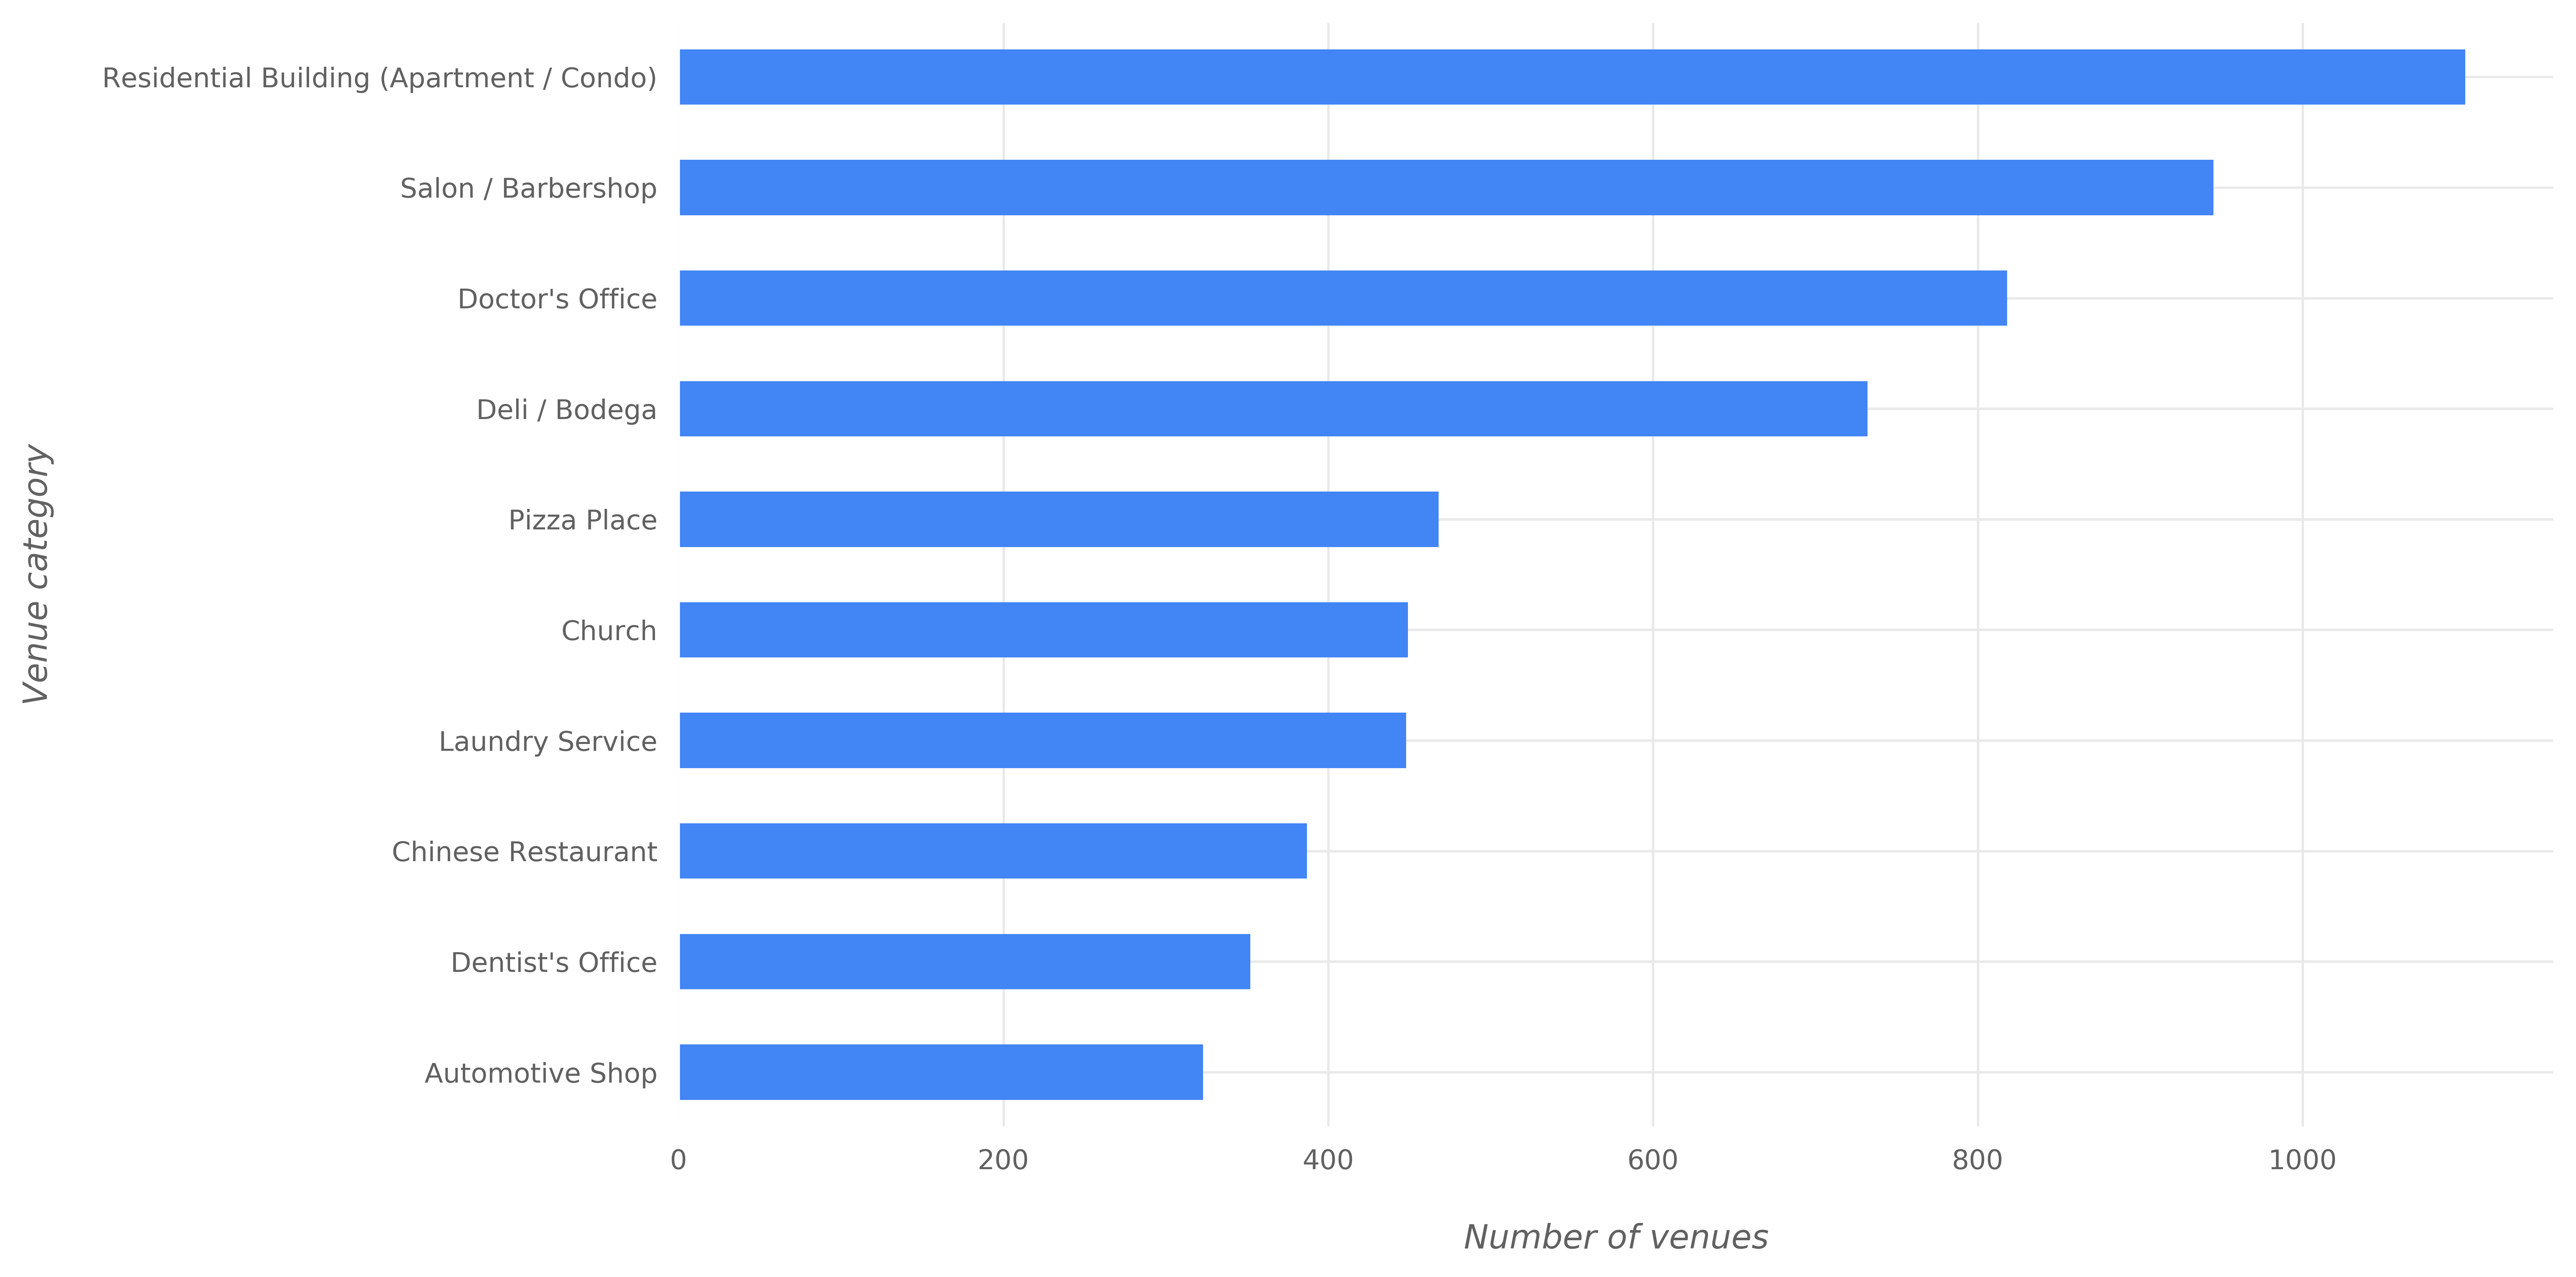

In [75]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)

nyc_top_vc = nyc_venues['Venue Category'].value_counts(normalize=False)

ax = nyc_top_vc.head(10).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

<a id='comv-tor'></a>
### Top 10 Common Venue Categories in Toronto

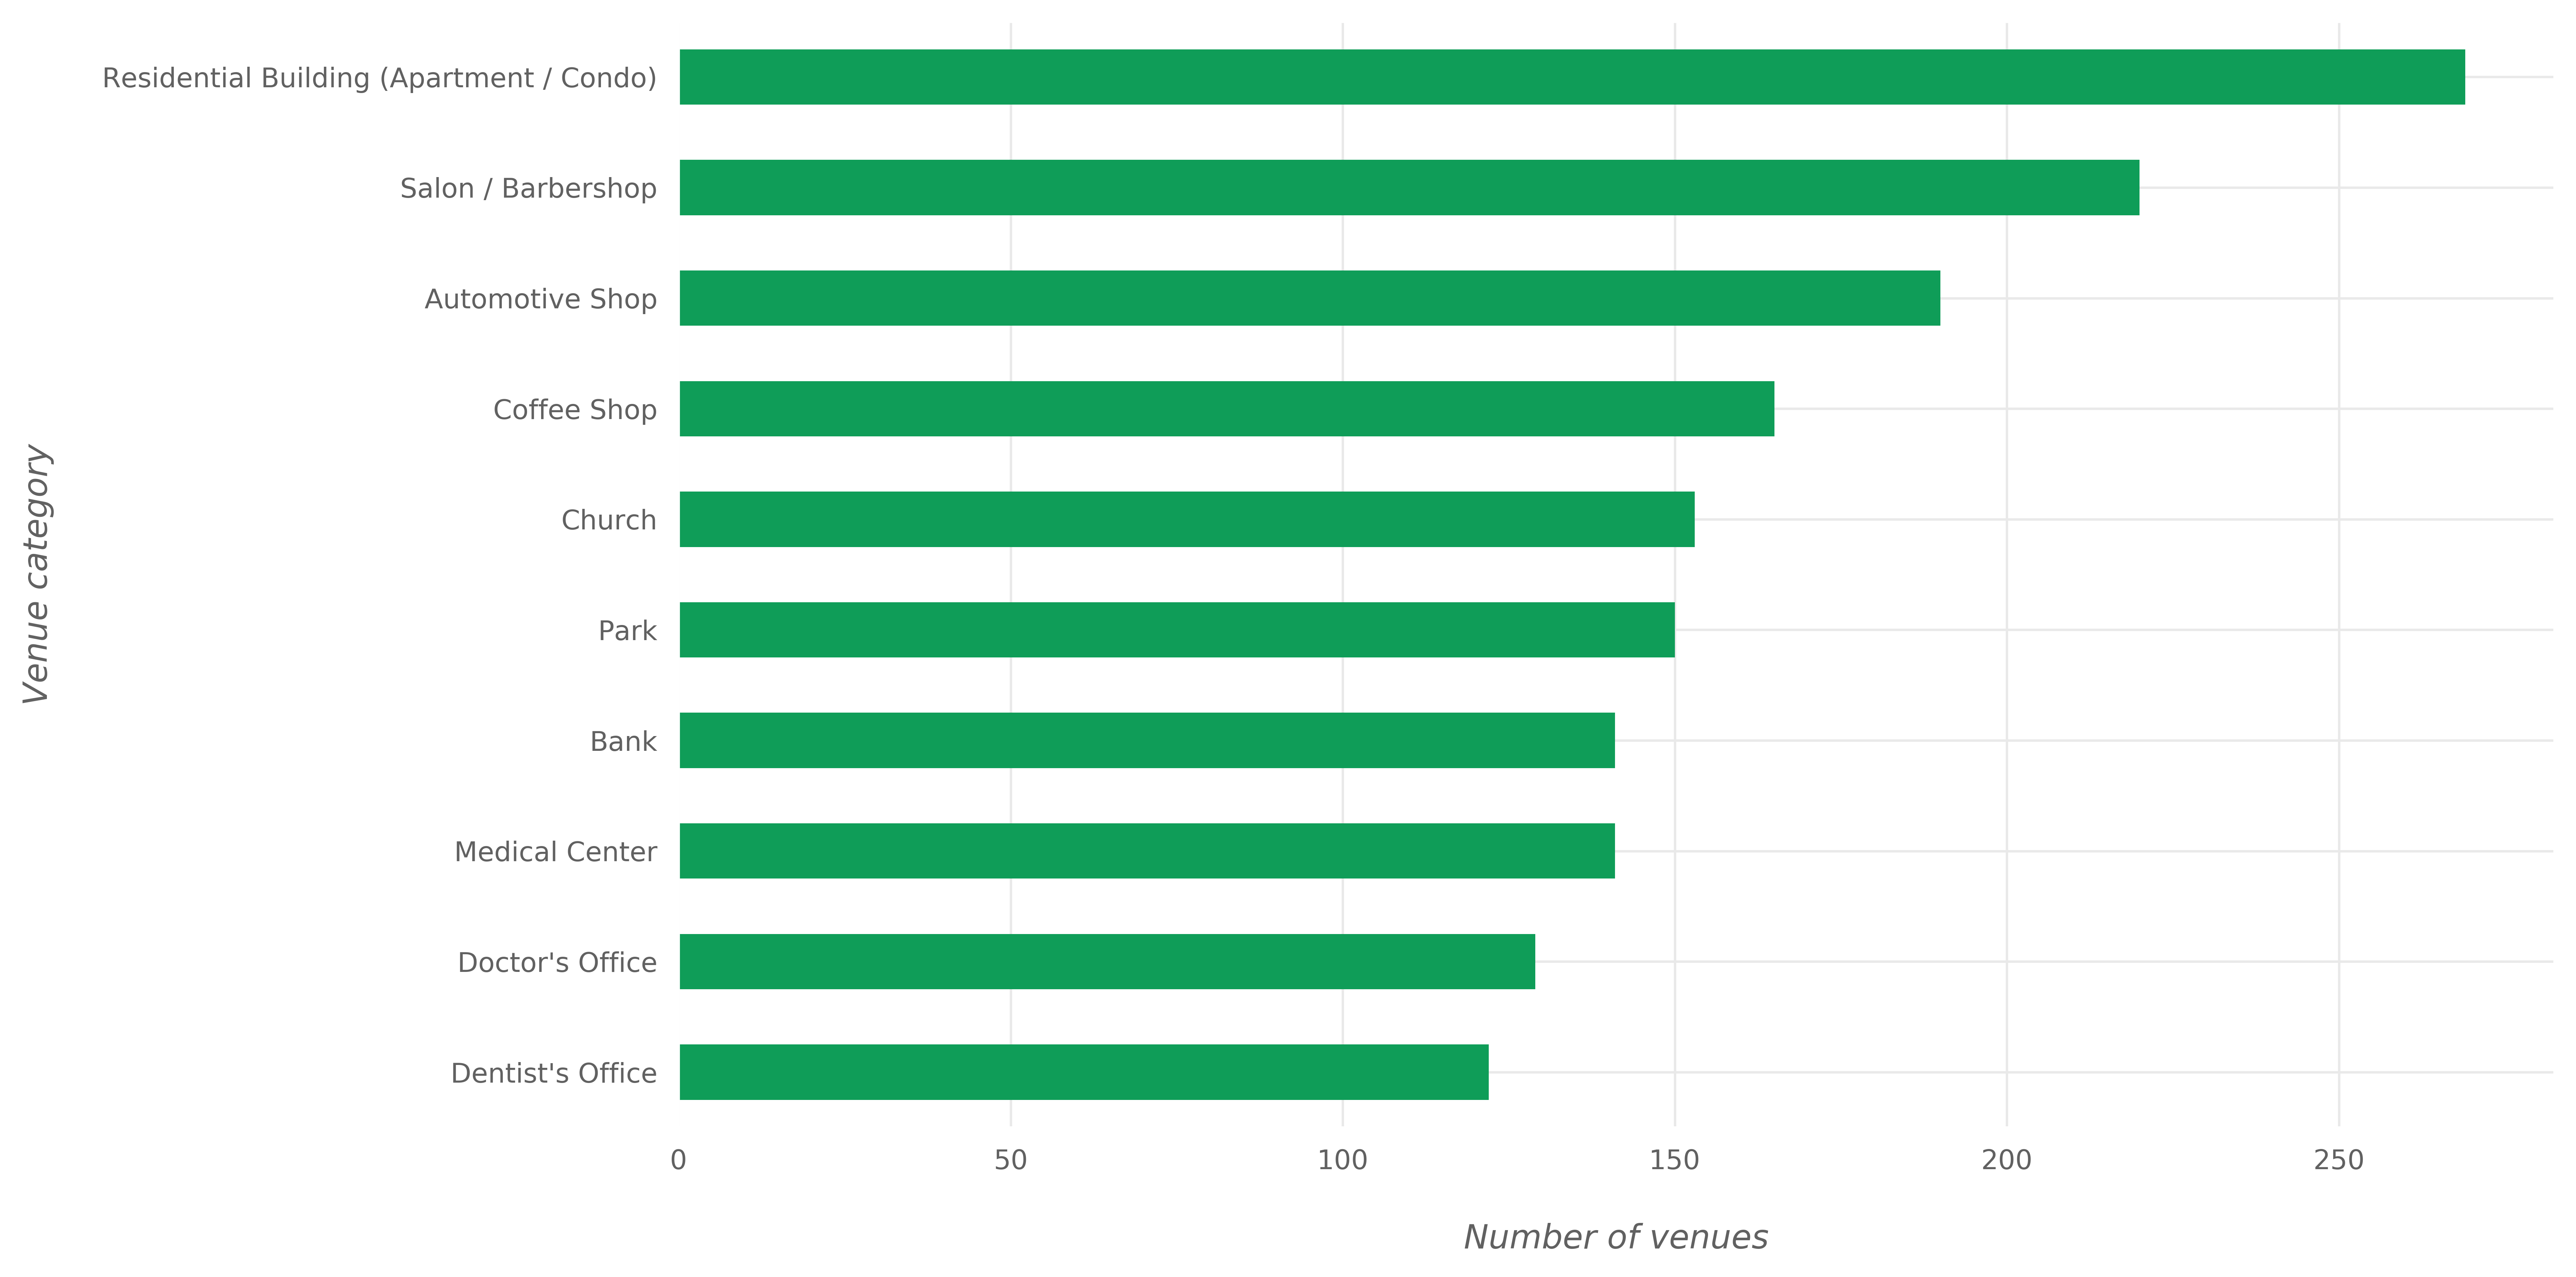

In [76]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)

tor_top_vc = tor_venues['Venue Category'].value_counts(normalize=False)

ax = tor_top_vc.head(10).plot(kind='barh', color=pc[3]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

<a id='comvc'></a>
### Top 10 Venue Categories that Exist in Most NYC Neighborhoods

306 neighborhoods in NYC


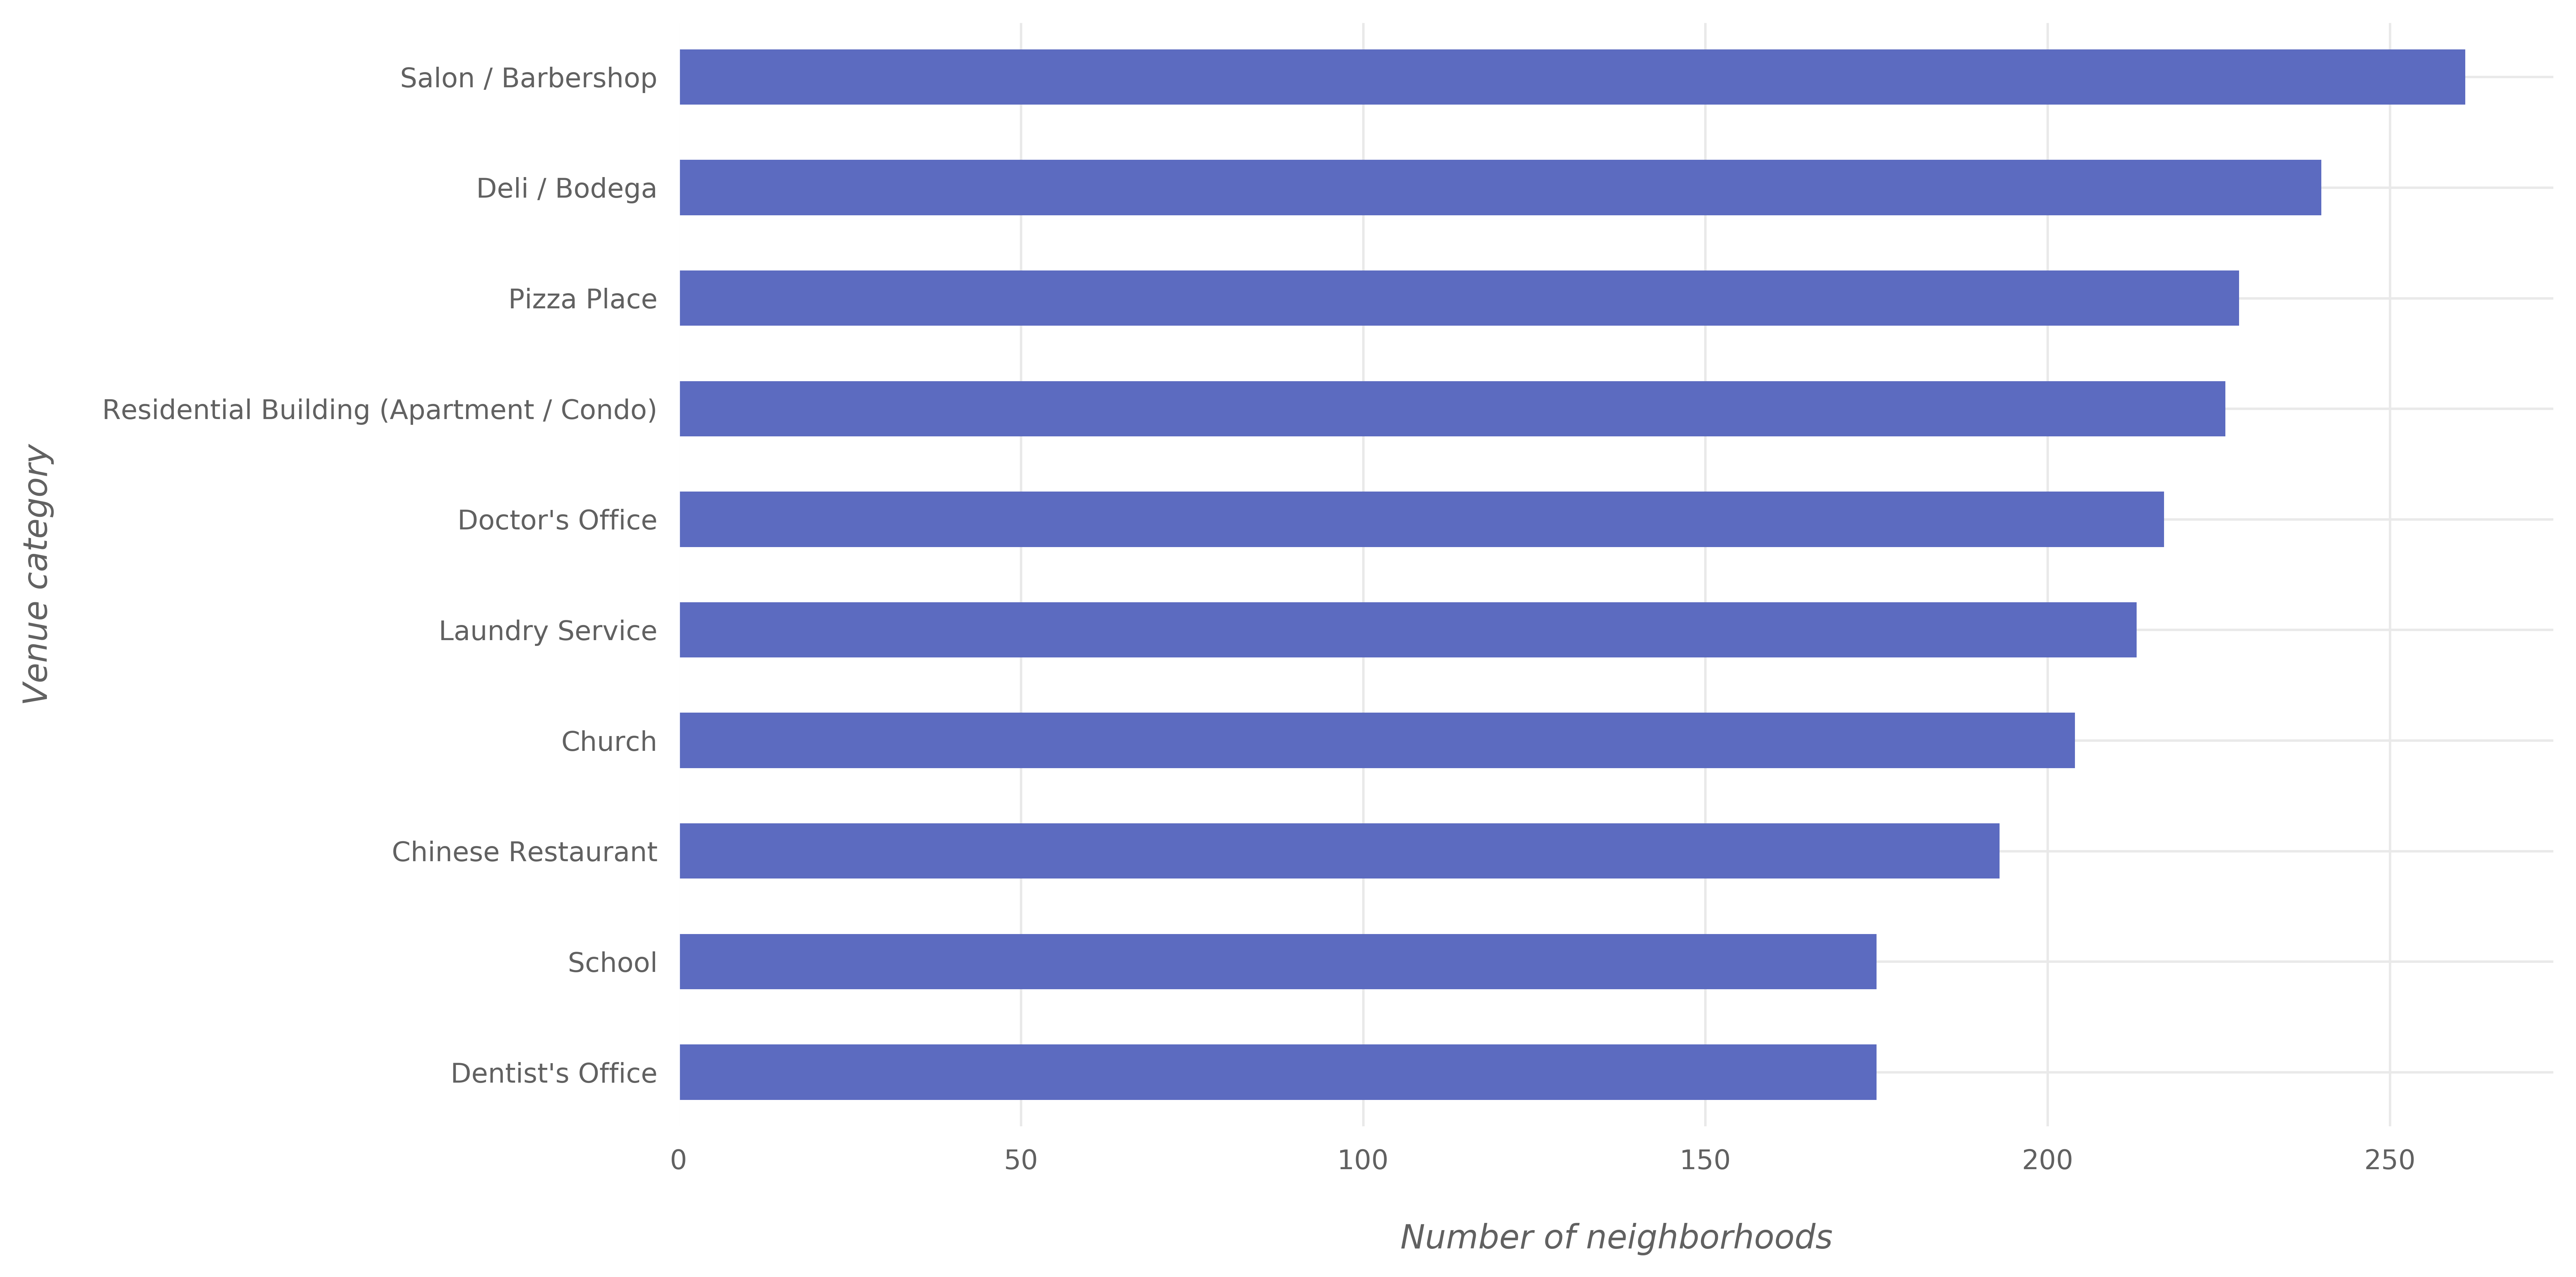

In [77]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)

nyc_g = nyc_onehot.groupby('Neighborhood').max().reset_index()
nyc_p = nyc_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)

print("{} neighborhoods in NYC".format(nyc_g.shape[0]))

ax = nyc_p.head(10).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-nyc.png', dpi=300)

<a id='comvc-tor'></a>
### Top 10 Venue Categories that Exist in Most Toronto Neighborhoods

99 neighborhoods in Toronto


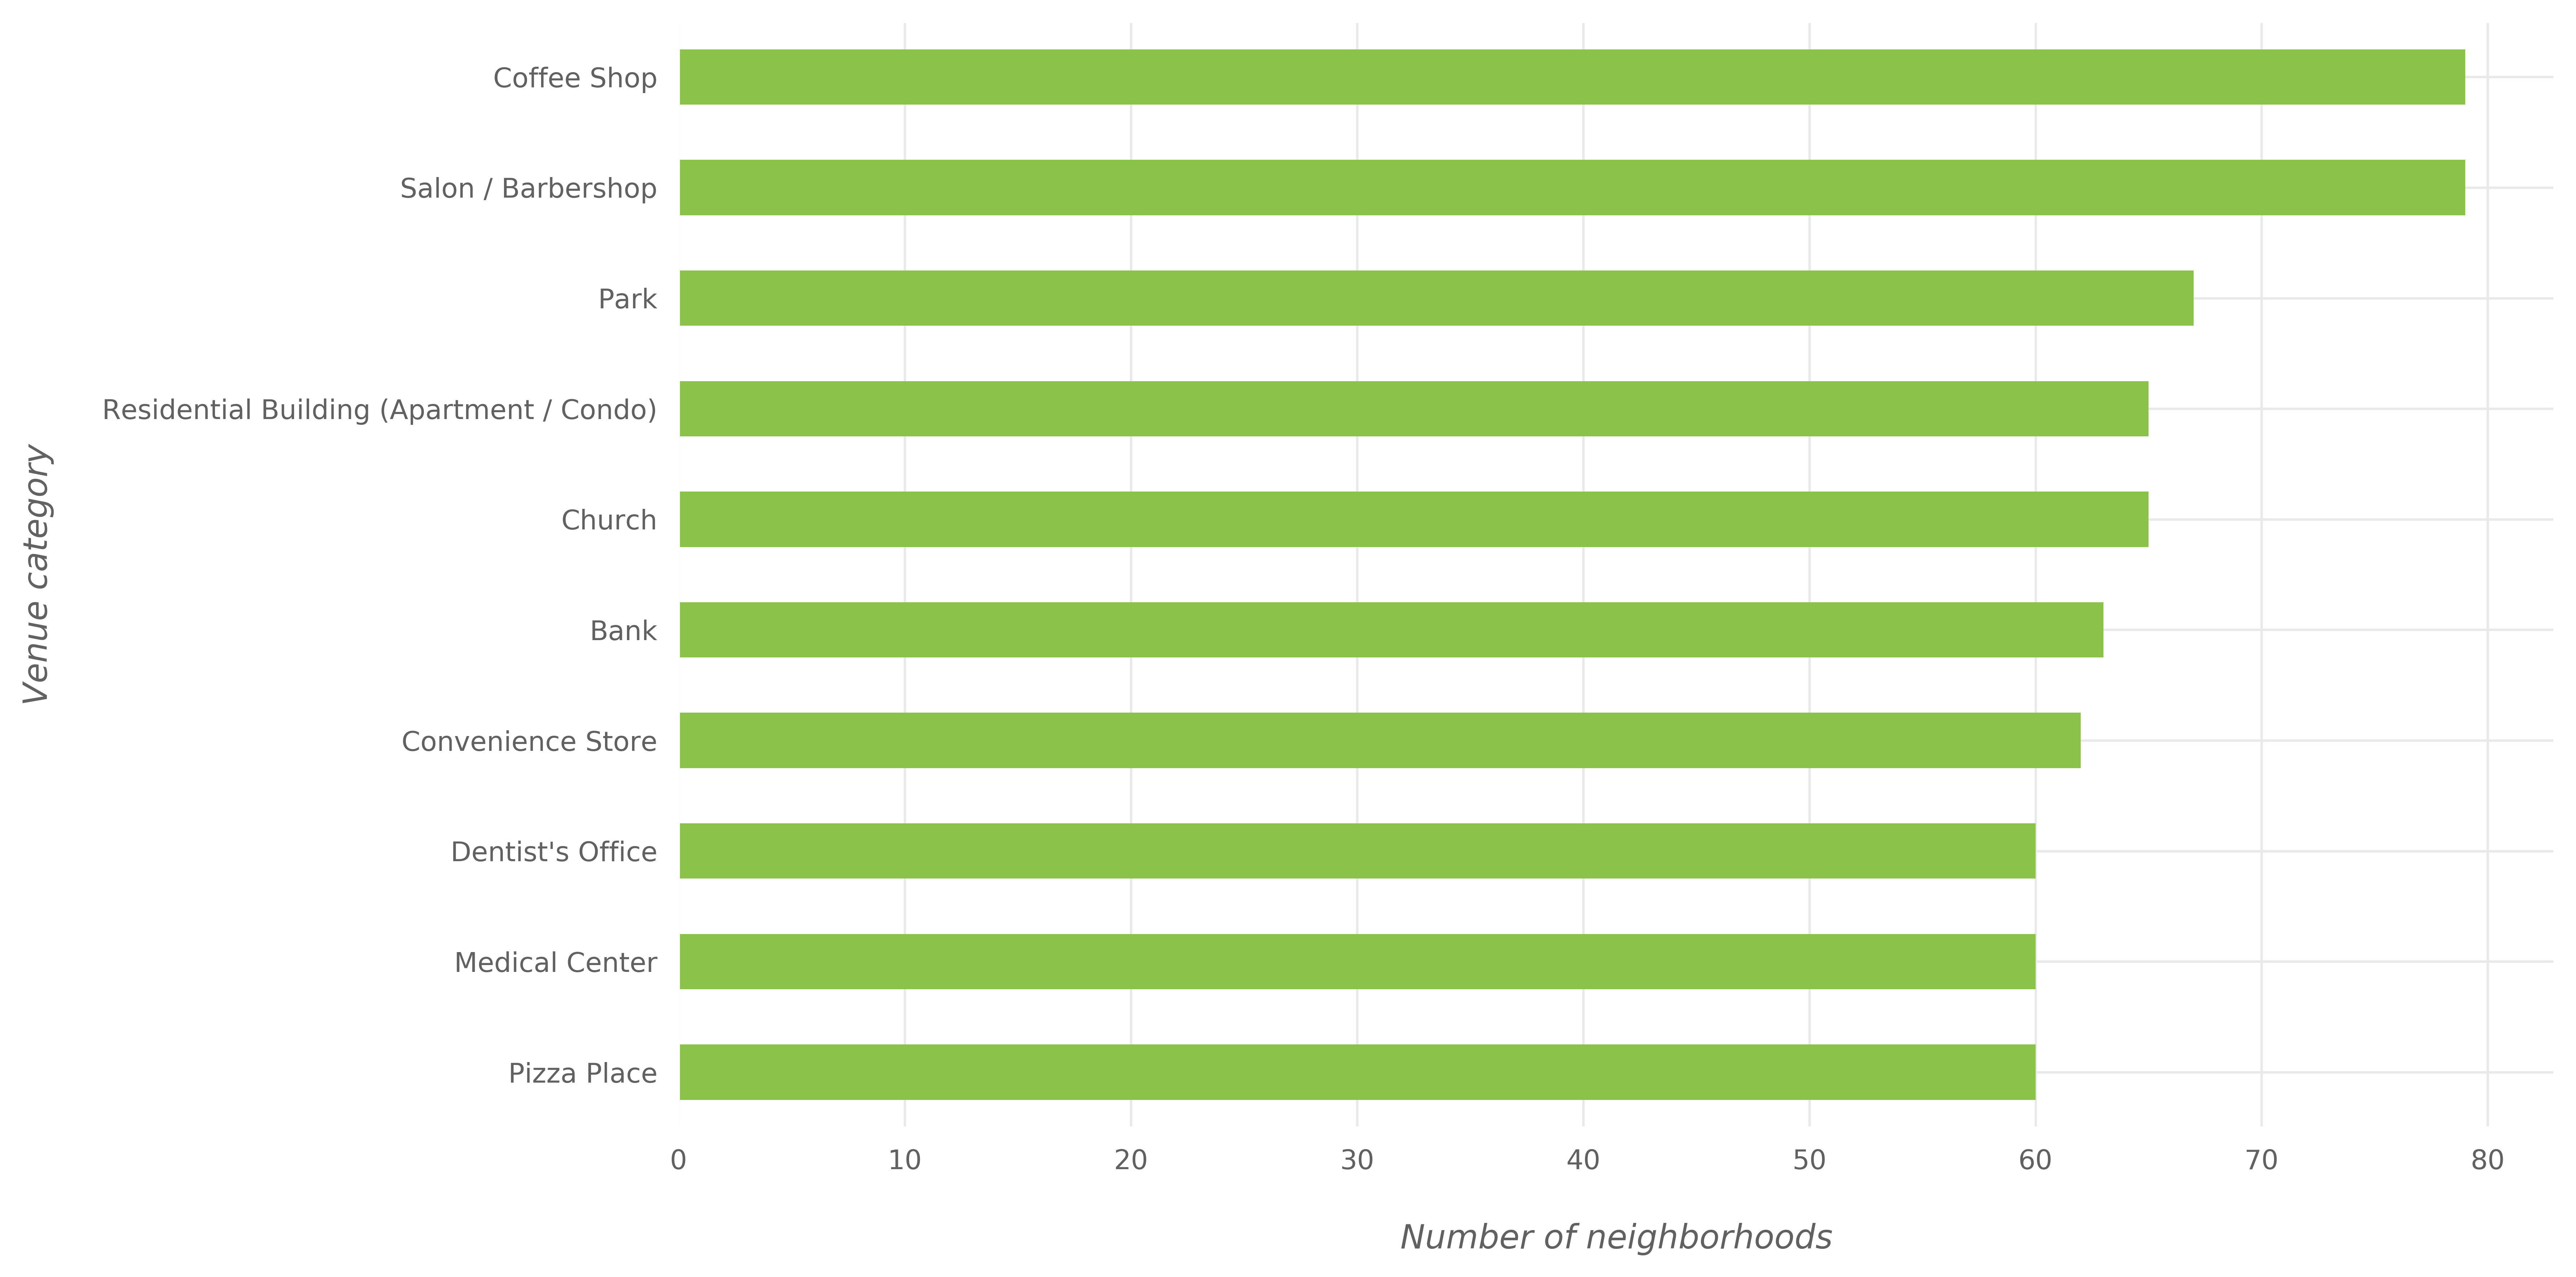

In [78]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)

tor_g = tor_onehot.groupby('Neighborhood').max().reset_index()
tor_p = tor_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)

print("{} neighborhoods in Toronto".format(tor_g.shape[0]))
ax = tor_p.head(10).plot(kind='barh', color=pc[14]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)

<a id='rarevc'></a>
### Rare Venue Categories in NYC

In [79]:
nyc_bot_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
nyc_bot_vc = nyc_bot_vc.tail(10).to_frame('Count')
nyc_bot_vc.index.names = ['Venue Category']
nyc_bot_vc

Count
Venue Category             
Colombian Restaurant      1
Light Rail Station        1
Line / Queue              1
Hunan Restaurant          1
Costume Shop              1
Roller Rink               1
Cable Car                 1
Caucasian Restaurant      1
Forest                    1
Adult Boutique            1

<a id='rarevc-tor'></a>
### Rare Venue Categories in Toronto

In [80]:
tor_bot_vc = tor_venues['Venue Category'].value_counts(normalize=False)
tor_bot_vc = tor_bot_vc.tail(10).to_frame('Count')
tor_bot_vc.index.names = ['Venue Category']
tor_bot_vc

Count
Venue Category              
Cable Car                  1
Language School            1
Roof Deck                  1
Baggage Claim              1
Carpet Store               1
Ski Chalet                 1
Pastry Shop                1
College Math Building      1
Stables                    1
Buffet                     1

### Combining NYC and Toronto data

In [81]:
clmns_nyc_only = set(nyc_grouped.columns).difference(set(tor_grouped.columns))
clmns_tor_only = set(tor_grouped.columns).difference(set(nyc_grouped.columns))

In [82]:
nyc_grouped_ = nyc_grouped.copy()
nyc_grouped_['Neighborhood'] = nyc_grouped_['Neighborhood'].apply(lambda x: x + '_NYC')

tor_grouped_ = tor_grouped.copy()
tor_grouped_['Neighborhood'] = tor_grouped_['Neighborhood'].apply(lambda x: x + '_Toronto')

for c in clmns_tor_only:
    nyc_grouped_[c] = 0
for c in clmns_nyc_only:
    tor_grouped_[c] = 0
    
all_clmns_sorted = ['Neighborhood'] + sorted(list(nyc_grouped_.drop('Neighborhood', axis=1).columns), 
                                              key=str.lower)
nyc_grouped_ = nyc_grouped_[all_clmns_sorted]
tor_grouped_ = tor_grouped_[all_clmns_sorted]
    
nyc_tor_grouped = pd.concat([nyc_grouped_, tor_grouped_]).reset_index(drop=True)

In [83]:
nyc_tor_grouped.loc[303:308,]

Neighborhood  Accessories Store  \
303                                        Woodrow_NYC                0.0   
304                                       Woodside_NYC                0.0   
305                                      Yorkville_NYC                0.0   
306                                  Agincourt_Toronto                0.0   
307                     Alderwood, Long Branch_Toronto                0.0   
308  Bathurst Manor, Wilson Heights, Downsview Nort...                0.0   

     Acupuncturist  Adult Boutique  Advertising Agency  Afghan Restaurant  \
303       0.000000             0.0                 0.0                0.0   
304       0.000000             0.0                 0.0                0.0   
305       0.011364             0.0                 0.0                0.0   
306       0.000000             0.0                 0.0                0.0   
307       0.000000             0.0                 0.0                0.0   
308       0.000000             0.0                 0.0                0.0   

     African Restaurant  Airport  Airport Food Court  Airport Gate  \
303                 0.0      0.0                 0.0           0.0   
304                 0.0      0.0                 0.0           0.0   
305                 0.0      0.0                 0.0           0.0   
306                 0.0      0.0                 0.0           0.0   
307                 0.0      0.0                 0.0           0.0   
308                 0.0      0.0                 0.0           0.0   

     Airport Lounge  Airport Service  Airport Terminal  Airport Tram  \
303             0.0              0.0               0.0           0.0   
304             0.0              0.0               0.0           0.0   
305             0.0              0.0               0.0           0.0   
306             0.0              0.0               0.0           0.0   
307             0.0              0.0               0.0           0.0   
308             0.0              0.0               0.0           0.0   

     Alternative Healer  American Restaurant  Animal Shelter  Antique Shop  \
303                 0.0               0.0125             0.0           0.0   
304                 0.0               0.0000             0.0           0.0   
305                 0.0               0.0000             0.0           0.0   
306                 0.0               0.0000             0.0           0.0   
307                 0.0               0.0000             0.0           0.0   
308                 0.0               0.0000             0.0           0.0   

     Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
303       0.0  0.0000               0.0                     0.0     0.012500   
304       0.0  0.0000               0.0                     0.0     0.000000   
305       0.0  0.0000               0.0                     0.0     0.011364   
306       0.0  0.0125               0.0                     0.0     0.000000   
307       0.0  0.0000               0.0                     0.0     0.000000   
308       0.0  0.0000               0.0                     0.0     0.012195   

     Art Museum  Art Studio  Arts & Crafts Store  Arts & Entertainment  \
303         0.0    0.000000             0.000000                   0.0   
304         0.0    0.000000             0.000000                   0.0   
305         0.0    0.000000             0.000000                   0.0   
306         0.0    0.000000             0.000000                   0.0   
307         0.0    0.012346             0.012346                   0.0   
308         0.0    0.000000             0.000000                   0.0   

     Asian Restaurant  Assisted Living  Astrologer  Athletics & Sports  \
303          0.000000              0.0         0.0            0.012500   
304          0.000000              0.0         0.0            0.000000   
305          0.000000              0.0         0.0            0.000000   
306          0.000000              0.0     

In [84]:
nyc_tor_grouped.shape

(405, 630)

In [85]:
# obtaining the most popular categories for each neighborhood
nyc_tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_tor_neighborhoods_categories_sorted['Neighborhood'] = nyc_tor_grouped['Neighborhood']

for ind in np.arange(nyc_tor_grouped.shape[0]):
    nyc_tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_tor_grouped.iloc[ind, :], num_top_cat)

nyc_tor_neighborhoods_categories_sorted.head()

Neighborhood     1st Most Common Category 2nd Most Common Category  \
0       Allerton_NYC           Salon / Barbershop          Laundry Service   
1       Annadale_NYC                  Pizza Place       Salon / Barbershop   
2  Arden Heights_NYC  Professional & Other Places          Doctor's Office   
3      Arlington_NYC                       Church           Hardware Store   
4       Arrochar_NYC                Deli / Bodega              Pizza Place   

  3rd Most Common Category     4th Most Common Category  \
0                     Food                  Gas Station   
1               Nail Salon                Tattoo Parlor   
2                   Church             Dentist's Office   
3       Salon / Barbershop  Professional & Other Places   
4               Food Truck                  Dry Cleaner   

                   5th Most Common Category 6th Most Common Category  \
0                               Pizza Place               Non-Profit   
1                       American Restaurant                Pet Store   
2                                       Bar                      Gym   
3  Residential Building (Apartment / Condo)          Automotive Shop   
4                              Dance Studio          Doctor's Office   

  7th Most Common Category  
0                 Car Wash  
1               Bagel Shop  
2    General Entertainment  
3      American Restaurant  
4                      Bar

<a id='comv-nt'></a>
### Top 10 Common Venue Categories in both NYC and Toronto

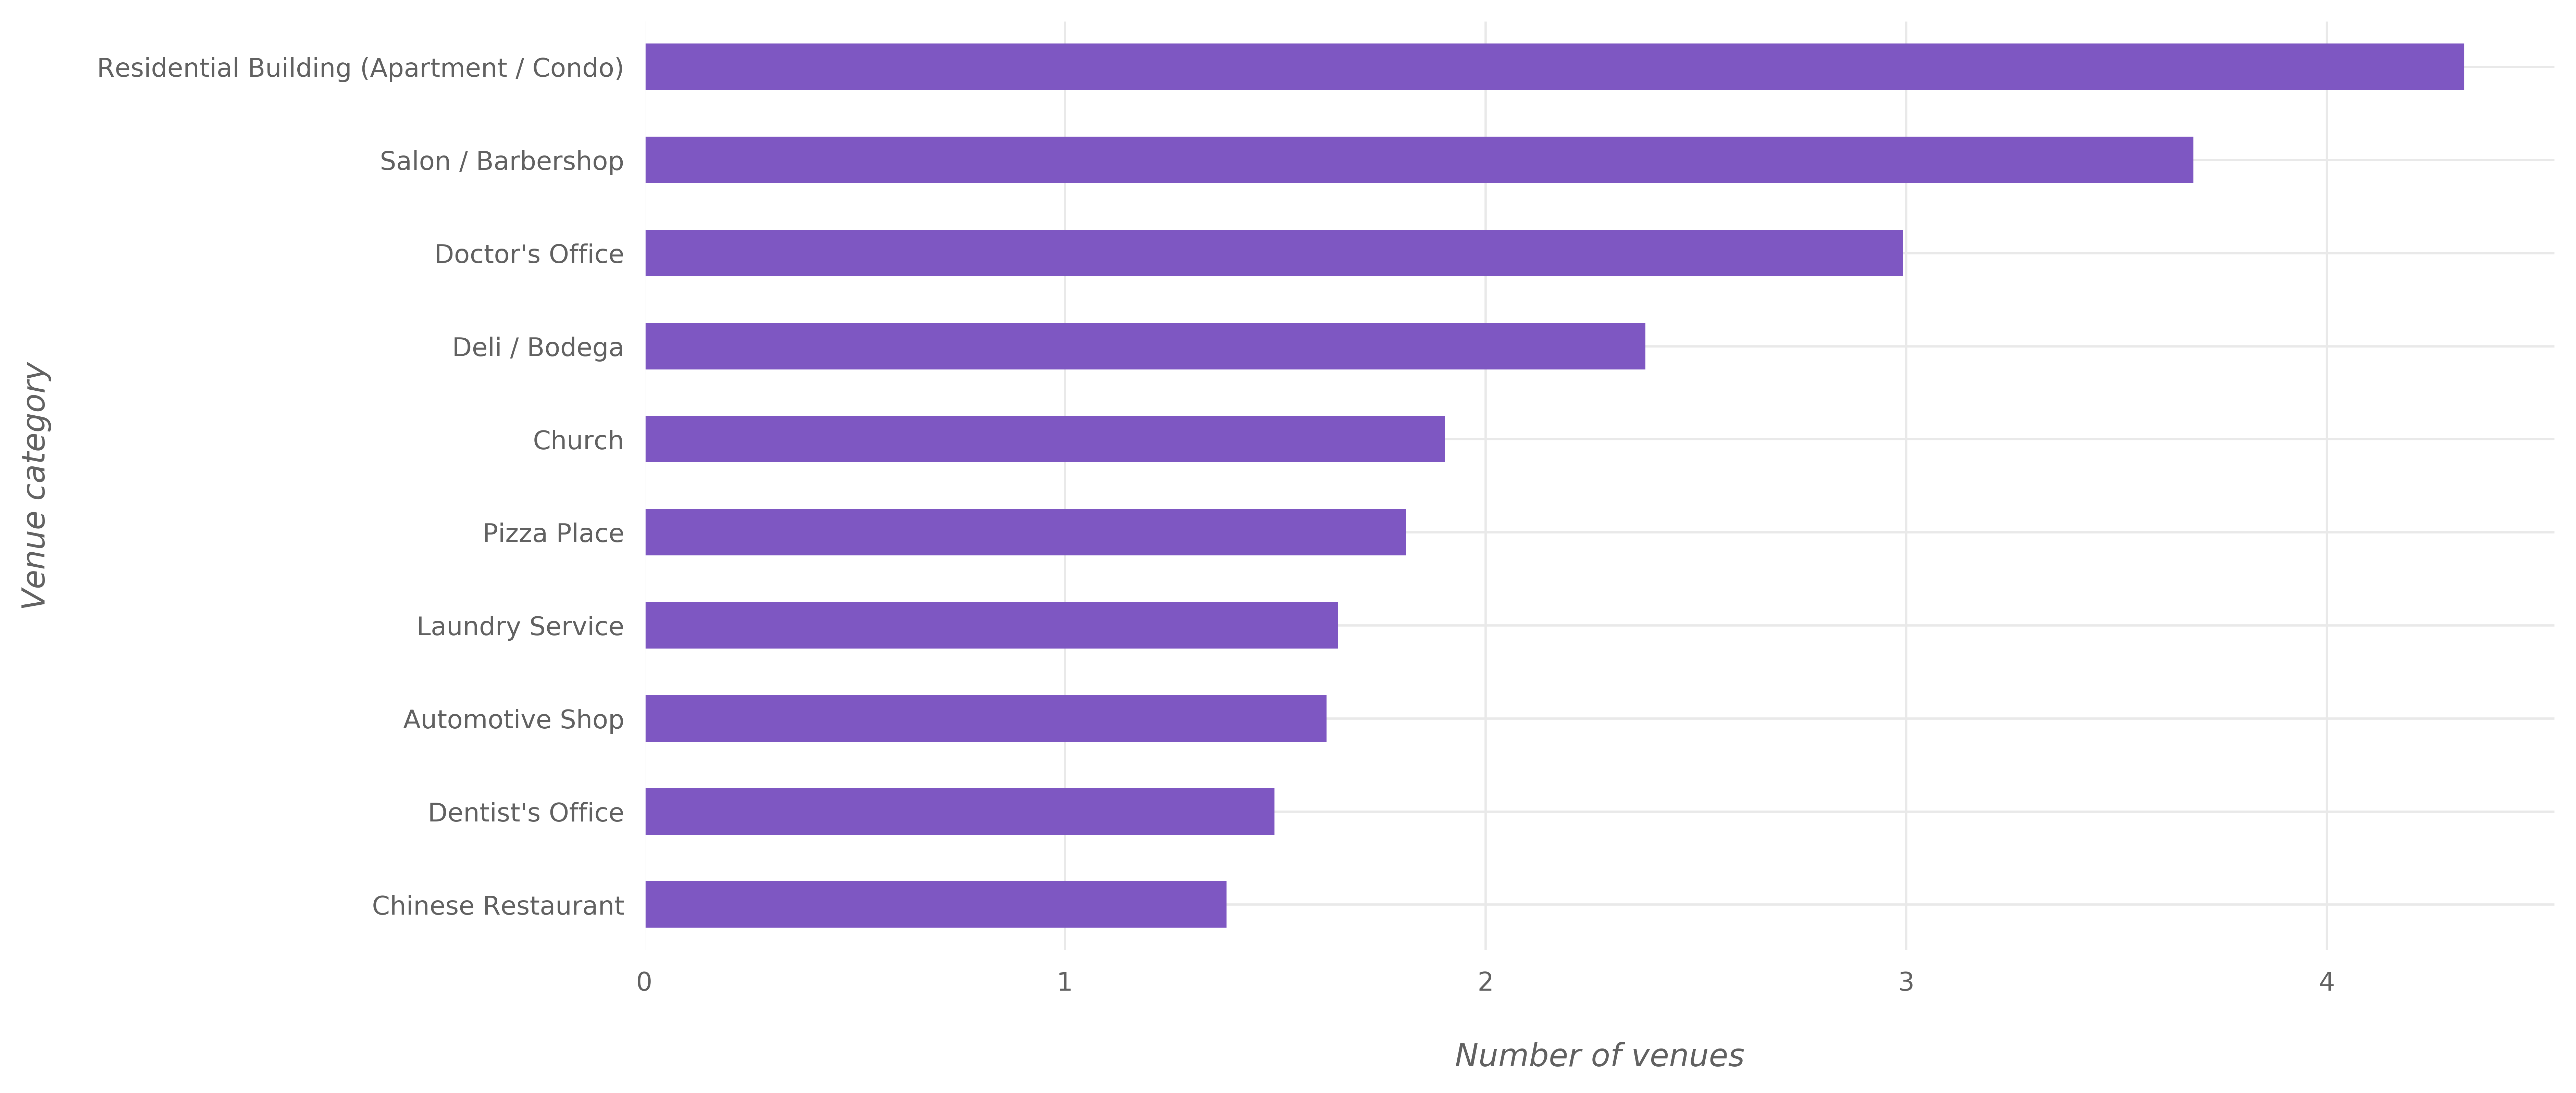

In [86]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_tor_top_vc = pd.concat([nyc_venues, tor_venues])['Venue Category'].value_counts(normalize=True) * 100
ax = nyc_tor_top_vc.head(10).plot(kind='barh', color=pc[12]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
fig.savefig('most-common-ven-nyc-tor.png', dpi=300)

<a id='rarevc-nt'></a>
### Rare Categories in both NYC and Toronto

In [87]:
nyc_tor_bot_vc = pd.concat([nyc_venues, tor_venues])['Venue Category'].value_counts(normalize=False)
nyc_tor_bot_vc = nyc_tor_bot_vc.tail(10).to_frame('Count')
nyc_tor_bot_vc.index.names = ['Venue Category']
nyc_tor_bot_vc

Count
Venue Category              
Aquarium                   1
Swim School                1
Roller Rink                1
Australian Restaurant      1
Newsagent                  1
Airport Food Court         1
Toll Booth                 1
Piercing Parlor            1
Stadium                    1
Rugby Pitch                1

### Clustering

In [88]:
# the number of clusters
kclusters = 5

# nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighborhood_', 1)
nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 4, 4, 3, 4, 2, 3, 0, 3], dtype=int32)

In [89]:
# add clustering labels
nyc_tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# nyc_tor_merged = nyc_tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
# tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
# nyc_tor_merged = nyc_tor_neighborhoods_categories_sorted.set_index('Neighborhood_')

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_tor_merged = nyc_tor_neighborhoods_categories_sorted.set_index('Neighborhood')

nyc_tor_merged.iloc[300:310] # check the last columns!

Cluster Labels  \
Neighborhood                                                         
Wingate_NYC                                                      3   
Woodhaven_NYC                                                    3   
Woodlawn_NYC                                                     3   
Woodrow_NYC                                                      4   
Woodside_NYC                                                     3   
Yorkville_NYC                                                    2   
Agincourt_Toronto                                                0   
Alderwood, Long Branch_Toronto                                   4   
Bathurst Manor, Wilson Heights, Downsview North...               1   
Bayview Village_Toronto                                          4   

                                                                    1st Most Common Category  \
Neighborhood                                                                                   
Wingate_NYC                                                               Salon / Barbershop   
Woodhaven_NYC                                                                  Deli / Bodega   
Woodlawn_NYC                                                                             Bar   
Woodrow_NYC                                                                             Pool   
Woodside_NYC                                                                             Bar   
Yorkville_NYC                                       Residential Building (Apartment / Condo)   
Agincourt_Toronto                                                            Automotive Shop   
Alderwood, Long Branch_Toronto                                             Convenience Store   
Bathurst Manor, Wilson Heights, Downsview North...                           Doctor's Office   
Bayview Village_Toronto                                                   Salon / Barbershop   

                                                                    2nd Most Common Category  \
Neighborhood                                                                                   
Wingate_NYC                                                                           School   
Woodhaven_NYC                                                             Salon / Barbershop   
Woodlawn_NYC                                                                   Deli / Bodega   
Woodrow_NYC                                                                    Grocery Store   
Woodside_NYC                                                              Salon / Barbershop   
Yorkville_NYC                                                                Laundry Service   
Agincourt_Toronto                                                           Storage Facility   
Alderwood, Long Branch_Toronto                                            Salon / Barbershop   
Bathurst Manor, Wilson Heights, Downsview North...  Residential Building (Apartment / Condo)   
Bayview Village_Toronto                                                      Doctor's Office   

                                                   3rd Most Common Category  \
Neighborhood                                                                  
Wingate_NYC                                                   Deli / Bodega   
Woodhaven_NYC                                               Laundry Service   
Woodlawn_NYC                                             Salon / Barbershop   
Woodrow_NYC                                                          School   
Woodside_NYC                                             Mexican Restaurant   
Yorkville_NYC                                                           Spa   
Agincourt_Toronto                                               Post Office   
Alderwood, Long Branch_Toronto                                          Spa   
Bathurst Manor, Wilson Heights, Downsview North...           Medical Center   
Bayview Village_Toronto             

<a id='exam-clust-tor'></a>
#### Examining clusters

Let's see the neighborhoods in each of the five clusters:


##### Cluster 1

In [90]:
c1 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 0, :]
print(c1.shape)
c1.iloc[60:70]

(18, 8)


Empty DataFrame
Columns: [Cluster Labels, 1st Most Common Category, 2nd Most Common Category, 3rd Most Common Category, 4th Most Common Category, 5th Most Common Category, 6th Most Common Category, 7th Most Common Category]
Index: []

Most common categories among all neighborhoods in this cluster:

##### Cluster 2

In [91]:
c2 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 1, :]
print(c2.shape)
c2

(43, 8)


Cluster Labels  \
Neighborhood                                                         
Bloomfield_NYC                                                   1   
Brooklyn Heights_NYC                                             1   
Bulls Head_NYC                                                   1   
Castleton Corners_NYC                                            1   
Concord_NYC                                                      1   
Dongan Hills_NYC                                                 1   
Dyker Heights_NYC                                                1   
Egbertville_NYC                                                  1   
Emerson Hill_NYC                                                 1   
Forest Hills_NYC                                                 1   
Fort Hamilton_NYC                                                1   
Georgetown_NYC                                                   1   
Glendale_NYC                                                     1   
Gramercy_NYC                                                     1   
Greenridge_NYC                                                   1   
Heartland Village_NYC                                            1   
Holliswood_NYC                                                   1   
Kew Gardens_NYC                                                  1   
Lindenwood_NYC                                                   1   
Madison_NYC                                                      1   
Manhattan Terrace_NYC                                            1   
Morris Park_NYC                                                  1   
Murray Hill, Manhattan_NYC                                       1   
New Springville_NYC                                              1   
Norwood_NYC                                                      1   
Oakwood_NYC                                                      1   
Ocean Parkway_NYC                                                1   
Park Hill_NYC                                                    1   
Pelham Gardens_NYC                                               1   
Pelham Parkway_NYC                                               1   
Pomonok_NYC                                                      1   
Randall Manor_NYC                                                1   
Rego Park_NYC                                                    1   
Rockaway Park_NYC                                                1   
Schuylerville_NYC                                                1   
South Beach_NYC                                                  1   
Starrett City_NYC                                                1   
Sunnyside, Staten Island_NYC                                     1   
Todt Hill_NYC                                                    1   
Tudor City_NYC                                                   1   
Upper East Side_NYC                                              1   
Bathurst Manor, Wilson Heights, Downsview North...               1   
Summerhill West, Rathnelly, South Hill, Forest ...               1   

                                                                    1st Most Common Category  \
Neighborhood                                                                                   
Bloomfield_NYC                                                               Doctor's Office   
Brooklyn Heights_NYC                                                         Doctor's Office   
Bulls Head_NYC                                                               Doctor's Office   
Castleton Corners_NYC                                                        Doctor's Office   
Concord_NYC                                                                  Doctor's Office   
Dongan Hills_NYC                                                               Deli / Bodega   
Dyker Heights_NYC                                                            Doctor's Office   
Egbertville_NYC                      

##### Cluster 3

In [92]:
c3 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 2, :]
print(c3.shape)
c3.tail()

(63, 8)


Cluster Labels  \
Neighborhood                                                  
The Annex, North Midtown, Yorkville_Toronto               2   
Victoria Village_Toronto                                  2   
Willowdale, Willowdale West_Toronto                       2   
York Mills West_Toronto                                   2   
York Mills, Silver Hills_Toronto                          2   

                                                             1st Most Common Category  \
Neighborhood                                                                            
The Annex, North Midtown, Yorkville_Toronto  Residential Building (Apartment / Condo)   
Victoria Village_Toronto                     Residential Building (Apartment / Condo)   
Willowdale, Willowdale West_Toronto          Residential Building (Apartment / Condo)   
York Mills West_Toronto                      Residential Building (Apartment / Condo)   
York Mills, Silver Hills_Toronto             Residential Building (Apartment / Condo)   

                                            2nd Most Common Category  \
Neighborhood                                                           
The Annex, North Midtown, Yorkville_Toronto          Bed & Breakfast   
Victoria Village_Toronto                             Automotive Shop   
Willowdale, Willowdale West_Toronto                             Park   
York Mills West_Toronto                                          Gym   
York Mills, Silver Hills_Toronto                                Park   

                                            3rd Most Common Category  \
Neighborhood                                                           
The Annex, North Midtown, Yorkville_Toronto      Japanese Restaurant   
Victoria Village_Toronto                               Grocery Store   
Willowdale, Willowdale West_Toronto                   Medical Center   
York Mills West_Toronto                                         Park   
York Mills, Silver Hills_Toronto                         High School   

                                            4th Most Common Category  \
Neighborhood                                                           
The Annex, North Midtown, Yorkville_Toronto            Metro Station   
Victoria Village_Toronto                         Government Building   
Willowdale, Willowdale West_Toronto                             Bank   
York Mills West_Toronto                               Medical Center   
York Mills, Silver Hills_Toronto                              Church   

                                            5th Most Common Category  \
Neighborhood                                                           
The Annex, North Midtown, Yorkville_Toronto               Playground   
Victoria Village_Toronto                             Auto Dealership   
Willowdale, Willowdale West_Toronto                        Synagogue   
York Mills West_Toronto                                       Church   
York Mills, Silver Hills_Toronto                                Pool   

                                            6th Most Common Category  \
Neighborhood                                                           
The Annex, North Midtown, Yorkville_Toronto       Miscellaneous Shop   
Victoria Village_Toronto                                  Playground   
Willowdale, Willowdale West_Toronto                      Pizza Place   
York Mills West_Toronto                                       School   
York Mills, Silver Hills_Toronto                              School   

                                               7th Most Common Category  
Neighborhood                                                             
The Annex, North Midtown, Yorkville_Toronto              Sandwich Place  
Victoria Village_Toronto                         Transportation Service  
Willowdale, Willowdale West_Toronto          Financial or Legal Service  
York Mills West_Toronto                                Dentist's Office  
York Mills

##### Cluster 4

In [93]:
c4 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 3, :]
print(c4.shape)
c4

(103, 8)


Cluster Labels  \
Neighborhood                                                         
Allerton_NYC                                                     3   
Annadale_NYC                                                     3   
Arrochar_NYC                                                     3   
Astoria Heights_NYC                                              3   
Bath Beach_NYC                                                   3   
Bay Ridge_NYC                                                    3   
Bedford Stuyvesant_NYC                                           3   
Beechhurst_NYC                                                   3   
Bellaire_NYC                                                     3   
Bellerose_NYC                                                    3   
Belmont_NYC                                                      3   
Bensonhurst_NYC                                                  3   
Boerum Hill_NYC                                                  3   
Cambria Heights_NYC                                              3   
Canarsie_NYC                                                     3   
Central Harlem_NYC                                               3   
City Line_NYC                                                    3   
Claremont Village_NYC                                            3   
Clinton Hill_NYC                                                 3   
Concourse Village_NYC                                            3   
Corona_NYC                                                       3   
Crown Heights_NYC                                                3   
Cypress Hills_NYC                                                3   
Douglaston_NYC                                                   3   
East Elmhurst_NYC                                                3   
East Flatbush_NYC                                                3   
East New York_NYC                                                3   
East Tremont_NYC                                                 3   
Edenwald_NYC                                                     3   
Edgewater Park_NYC                                               3   
Elm Park_NYC                                                     3   
Eltingville_NYC                                                  3   
Erasmus_NYC                                                      3   
Far Rockaway_NYC                                                 3   
Flatlands_NYC                                                    3   
Floral Park_NYC                                                  3   
Gravesend_NYC                                                    3   
Great Kills_NYC                                                  3   
High  Bridge_NYC                                                 3   
Highland Park_NYC                                                3   
Hollis_NYC                                                       3   
Homecrest_NYC                                                    3   
Howard Beach_NYC                                                 3   
Huguenot_NYC                                                     3   
Hunters Point_NYC                                                3   
Inwood_NYC                                                       3   
Jamaica Center_NYC                                               3   
Jamaica Hills_NYC                                                3   
Kingsbridge_NYC                                                  3   
Laurelton_NYC                                                    3   
Little Italy_NYC                                                 3   
Little Neck_NYC                                                  3   
Longwood_NYC                                                     3   
Manhattan Valley_NYC                                             3   
Marble Hill_NYC                                                  3   
Maspeth_NYC                                                   

##### Cluster 5

In [94]:
c5 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 4, :]
print(c5.shape)
c5

(178, 8)


Cluster Labels  \
Neighborhood                                                         
Arden Heights_NYC                                                4   
Arlington_NYC                                                    4   
Arverne_NYC                                                      4   
Bay Terrace, Staten Island_NYC                                   4   
Baychester_NYC                                                   4   
Bayside_NYC                                                      4   
Bayswater_NYC                                                    4   
Belle Harbor_NYC                                                 4   
Bergen Beach_NYC                                                 4   
Borough Park_NYC                                                 4   
Breezy Point_NYC                                                 4   
Brighton Beach_NYC                                               4   
Broad Channel_NYC                                                4   
Broadway Junction_NYC                                            4   
Brookville_NYC                                                   4   
Brownsville_NYC                                                  4   
Bushwick_NYC                                                     4   
Butler Manor_NYC                                                 4   
Carroll Gardens_NYC                                              4   
Castle Hill_NYC                                                  4   
Charleston_NYC                                                   4   
Chelsea, Manhattan_NYC                                           4   
Chelsea, Staten Island_NYC                                       4   
Chinatown_NYC                                                    4   
City Island_NYC                                                  4   
Civic Center_NYC                                                 4   
Clason Point_NYC                                                 4   
Clifton_NYC                                                      4   
Clinton_NYC                                                      4   
Co-op City_NYC                                                   4   
Coney Island_NYC                                                 4   
Country Club_NYC                                                 4   
Downtown_NYC                                                     4   
Dumbo_NYC                                                        4   
East Harlem_NYC                                                  4   
Edgemere_NYC                                                     4   
Fieldston_NYC                                                    4   
Financial District_NYC                                           4   
Flatiron_NYC                                                     4   
Flushing_NYC                                                     4   
Fordham_NYC                                                      4   
Fox Hills_NYC                                                    4   
Fulton Ferry_NYC                                                 4   
Gerritsen Beach_NYC                                              4   
Glen Oaks_NYC                                                    4   
Gowanus_NYC                                                      4   
Graniteville_NYC                                                 4   
Grant City_NYC                                                   4   
Grasmere_NYC                                                     4   
Greenpoint_NYC                                                   4   
Grymes Hill_NYC                                                  4   
Hammels_NYC                                                      4   
Hillcrest_NYC                                                    4   
Howland Hook_NYC                                                 4   
Hudson Yards_NYC                                                 4   
Jamaica Estates_NYC                                           

In [95]:
clust_cats = []
clusters = [c1, c2, c3, c4, c5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('NYC'):
            nn = n[:-4]
            clust_cats[i].extend(list(nyc_venues[nyc_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-8]
            clust_cats[i].extend(list(tor_venues[tor_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100


In [96]:
# clust_cats[0]

In [97]:
# Color configuration
# Reference: # Reference: https://github.com/ammar1y

tbl_bck = "#363636"
tbl_hdr_bck = "#363636"
tbl_txt = "#BBBBBB"

styles = [
    dict(selector="td", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector="th", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector=".col0", props=[("border-left", "1px solid #bbbbbb")]), 
    
    dict(selector="th.blank:nth-child(2)", props=[("border-left", "1px solid #bbbbbb")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("padding-top", "0"), ("padding-bottom", "8px")]),
    
    dict(selector="th.col_heading", props=[("background", tbl_hdr_bck), 
                                           ("color", "#FFCA91")]),
    
    dict(selector="th.index_name", props=[("background", tbl_hdr_bck), 
                                          ("color", "#8DCDFF")]),
    
    dict(selector="th.blank", props=[("background", tbl_hdr_bck), ("padding", "0")]),
    
    dict(selector="tr:nth-child(2n)", props=[("background", "white")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "1px solid {}".format(tbl_txt))]),
    
    dict(selector="thead tr:nth-child(1) th", props=[("padding-top", "14px !important")]),
    
    dict(selector="tbody tr:last-child td", props=[("padding-bottom", "20px")]),
    
    dict(selector="tbody tr:last-child th", props=[("padding-bottom", "20px")]),
    
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "#8DCDFF")]),
]

In [98]:
for i in range(kclusters):
    c__ = clust_cats[i].to_frame("% of venues")
    c__.index.names = ['Category']
    html = (c__.head(7).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse; border: 2px solid #BBBBBB"'))
    display(HTML(disp_fmt.format("Cluster {}".format(i+1))))
    display(html)

<a id='results'></a>

## Discussion

Our analysis shows that NYC and Toronto have the same Top 2 common venue categories: apartments and barbershops.

The Top 10 Common Venue Categories suggest what types of businesses are more likely to thrive.

The Rare Categories suggest what types of businesses are less desirable.


<a id='conclusion'></a>

## Conclusion

The neighborhoods of New York City and Toronto were clustered into multiple groups based on the categories of the venues in these neighborhoods. The results show that there are venue categories that are more common in some cluster than the others.